# FixMatch with MNIST

Implementation based on https://github.com/amarmeddahi/fix-match

In [ ]:
# Import
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import sys

# Utils function

Cette partie contient des fonctions utiles pour le traitements des données générées par l'entrainement (affichage, sauvegarde, etc).

## Smoothing results

In [ ]:
def smoothing_values(values,range_smoothing=250):
  if len(values)<range_smoothing:
    raise Exception('Range smoothing higher than length of the given values')
  cond_stop = False
  values_out = []
  range_out = []
  step = 0
  next_step = 0
  while(not(cond_stop)):
    if len(values_out) == 0: # If only started, the first value smooth will be only half of the range
      next_step = math.ceil(range_smoothing/2)
      range_out.append(0)
    else:
      next_step = min(step+range_smoothing,len(values))
      range_out.append(int((step+next_step)/2))
    value_smooth = sum(values[step:next_step])/(next_step-step)
    values_out.append(value_smooth)
    step = next_step
    cond_stop = (step==len(values))
  return [range_out,values_out]

## Drawing figures

In [ ]:
def draw_results_raw(losses,losses_lab,losses_unlab,
 train_acc_FixMatch,test_acc_FixMatch,
 train_acc_noAug,test_acc_noAug,
 train_acc_weakAug,test_acc_weakAug,
 train_acc_strongAug,test_acc_strongAug,
 pseudo_lab,false_pseudo_lab,nb_lab):
  # Plot the results (losses, accuracies, pseudo labels)
  plt.figure(figsize=(15,10))
  plt.subplot(2,3,1)
  plt.plot(losses, label='Total')
  plt.plot(losses_lab, label='Lab')
  plt.plot(losses_unlab, label='Unlab')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Losses evolution of semi-supervised model FixMatch")
  plt.legend()
  plt.subplot(2,3,2)
  plt.plot(train_acc_FixMatch, label='Train')
  plt.plot(test_acc_FixMatch, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Model semi-supervised FixMatch")
  plt.legend()
  plt.subplot(2,3,3)
  plt.plot(pseudo_lab,label="Considered valid")
  plt.plot(false_pseudo_lab,label="Wrong")
  plt.xlabel('Epoch')
  plt.ylabel('Part of Pseudo Labels')
  plt.legend()
  plt.title("Evolution of Pseudo Labels valid of FixMatch")
  plt.subplot(2,3,4)
  plt.plot(train_acc_noAug, label='Train')
  plt.plot(test_acc_noAug, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model supervised with no aumgentation")
  plt.legend()
  plt.subplot(2,3,5)
  plt.plot(train_acc_weakAug, label='Train')
  plt.plot(test_acc_weakAug, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model supervised with weak aumgentation")
  plt.legend()
  plt.subplot(2,3,6)
  plt.plot(train_acc_strongAug, label='Train')
  plt.plot(test_acc_strongAug, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model supervised with strong aumgentation")
  plt.legend()
  plt.suptitle(f" Models results with {nb_lab} labeled data")
  plt.savefig(f"Results_raw_{nb_lab}.png")
  plt.show()
  plt.figure()
  plt.plot(test_acc_FixMatch, label="Semi-supervised FixMatch")
  plt.plot(test_acc_noAug, label="Supervised no Augmentation")
  plt.plot(test_acc_weakAug, label="Supervised weak Augmentation")
  plt.plot(test_acc_strongAug, label="Supervised strong Augmentation")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title(f"Test accuracies of models with {nb_lab} labeled data")
  plt.legend()
  plt.savefig(f"Comparaison_raw_{nb_lab}.png")
  plt.show()



def draw_results_smooth(losses,losses_lab,losses_unlab,
 train_acc_FixMatch,test_acc_FixMatch,
 train_acc_noAug,test_acc_noAug,
 train_acc_weakAug,test_acc_weakAug,
 train_acc_strongAug,test_acc_strongAug,
 pseudo_lab,false_pseudo_lab,nb_lab):
 # Plot the results (losses, accuracies, pseudo labels)
  plt.figure(figsize=(15,10))
  plt.subplot(2,3,1)
  [range_losses,smooth_losses] = smoothing_values(losses)
  plt.plot(range_losses,smooth_losses, label='Total')
  [range_losses_lab,smooth_losses_lab] = smoothing_values(losses_lab)
  plt.plot(range_losses_lab,smooth_losses_lab, label='Lab')
  [range_losses_unlab,smooth_losses_unlab] = smoothing_values(losses_unlab)
  plt.plot(range_losses_unlab,smooth_losses_unlab, label='Unlab')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Losses evolution of semi-supervised model FixMatch")
  plt.legend()
  plt.subplot(2,3,2)
  [range_train_acc_FixMatch,smooth_train_acc_FixMatch] = smoothing_values(train_acc_FixMatch)
  [range_test_acc_FixMatch,smooth_test_acc_FixMatch] = smoothing_values(test_acc_FixMatch)
  plt.plot(range_train_acc_FixMatch,smooth_train_acc_FixMatch, label='Train')
  plt.plot(range_test_acc_FixMatch,smooth_test_acc_FixMatch, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model semi-supervised FixMatch")
  plt.legend()
  plt.subplot(2,3,3)
  [range_pseudo_lab,smooth_pseudo_lab] = smoothing_values(pseudo_lab)
  [range_false_pseudo_lab,smooth_false_pseudo_lab] = smoothing_values(false_pseudo_lab)
  plt.plot(range_pseudo_lab,smooth_pseudo_lab,label="Considered valid")
  plt.plot(range_false_pseudo_lab,smooth_false_pseudo_lab,label="Wrong")
  plt.xlabel('Epoch')
  plt.ylabel('Part of Pseudo Labels')
  plt.legend()
  plt.title("Evolution of Pseudo Labels valid of FixMatch")
  plt.subplot(2,3,4)
  [range_train_acc_noAug,smooth_train_acc_noAug] = smoothing_values(train_acc_noAug)
  [range_test_acc_noAug,smooth_test_acc_noAug] = smoothing_values(test_acc_noAug)
  plt.plot(range_train_acc_noAug,smooth_train_acc_noAug, label='Train')
  plt.plot(range_test_acc_noAug,smooth_test_acc_noAug, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model supervised with no aumgentation")
  plt.legend()
  plt.subplot(2,3,5)
  [range_train_acc_weakAug,smooth_train_acc_weakAug] = smoothing_values(train_acc_weakAug)
  [range_test_acc_weakAug,smooth_test_acc_weakAug] = smoothing_values(test_acc_weakAug)
  plt.plot(range_train_acc_weakAug,smooth_train_acc_weakAug, label='Train')
  plt.plot(range_test_acc_weakAug,smooth_test_acc_weakAug, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model supervised with weak aumgentation")
  plt.legend()
  plt.subplot(2,3,6)
  [range_train_acc_strongAug,smooth_train_acc_strongAug] = smoothing_values(train_acc_strongAug)
  [range_test_acc_strongAug,smooth_test_acc_strongAug] = smoothing_values(test_acc_strongAug)
  plt.plot(range_train_acc_strongAug,smooth_train_acc_strongAug, label='Train')
  plt.plot(range_test_acc_strongAug,smooth_test_acc_strongAug, label='Test')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title("Model supervised with strong aumgentation")
  plt.legend()
  plt.suptitle(f" Models results with {nb_lab} labeled data")
  plt.savefig(f"Results_smooth_{nb_lab}.png")
  plt.show()
  plt.figure()
  plt.plot(range_test_acc_FixMatch,smooth_test_acc_FixMatch, label="Semi-supervised FixMatch")
  plt.plot(range_test_acc_noAug,smooth_test_acc_noAug, label="Supervised no Augmentation")
  plt.plot(range_test_acc_weakAug,smooth_test_acc_weakAug, label="Supervised weak Augmentation")
  plt.plot(range_test_acc_strongAug,smooth_test_acc_strongAug, label="Supervised strong Augmentation")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title(f"Test accuracies of models with {nb_lab} labeled data")
  plt.legend()
  plt.savefig(f"Comparaison_smooth_{nb_lab}.png")
  plt.show()

def draw_comparaison(test_acc_100,test_acc_50,test_acc_10,test_acc_100_s,test_acc_50_s,test_acc_50_w,test_acc_10_s,test_acc_10_w):
  [range_test_acc_100,smooth_test_acc_100] = smoothing_values(test_acc_100)
  [range_test_acc_50,smooth_test_acc_50] = smoothing_values(test_acc_50)
  [range_test_acc_10,smooth_test_acc_10] = smoothing_values(test_acc_10)
  [range_test_acc_100_s,smooth_test_acc_100_s] = smoothing_values(test_acc_100_s)
  [range_test_acc_50_s,smooth_test_acc_50_s] = smoothing_values(test_acc_50_s)
  [range_test_acc_50_w,smooth_test_acc_50_w] = smoothing_values(test_acc_50_w)
  [range_test_acc_10_s,smooth_test_acc_10_s] = smoothing_values(test_acc_10_s)
  [range_test_acc_10_w,smooth_test_acc_10_w] = smoothing_values(test_acc_10_w)
  plt.figure()
  plt.plot(range_test_acc_100,smooth_test_acc_100, label="100 random labels")
  plt.plot(range_test_acc_50,smooth_test_acc_50, label="50 random labels")
  plt.plot(range_test_acc_10,smooth_test_acc_10, label="10 random labels")
  plt.plot(range_test_acc_100_s,smooth_test_acc_100_s, label="100 selected labels by strong Aug")
  plt.plot(range_test_acc_50_s,smooth_test_acc_50_s, label="50 selected labels by strong Aug")
  plt.plot(range_test_acc_50_w,smooth_test_acc_50_w, label="50 selected labels by weak Aug")
  plt.plot(range_test_acc_10_s,smooth_test_acc_10_s, label="10 selected labels by strong Aug")
  plt.plot(range_test_acc_10_w,smooth_test_acc_10_w, label="10 selected labels by weak Aug")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0)
  plt.title(f"Test accuracies of FixMatch with different data labeled")
  plt.legend()
  plt.savefig(f"FixMath_comp_smooth_all.png")
  plt.show()


## Saving results

In [ ]:
def save_results(losses,losses_lab,losses_unlab,
 train_acc_FixMatch,test_acc_FixMatch,
 train_acc_noAug,test_acc_noAug,
 train_acc_weakAug,test_acc_weakAug,
 train_acc_strongAug,test_acc_strongAug,
 pseudo_lab,false_pseudo_lab,nb_lab):
    results = [np.asarray(losses),np.asarray(losses_lab),np.asarray(losses_unlab),
               np.asarray(train_acc_FixMatch),np.asarray(test_acc_FixMatch),
               np.asarray(train_acc_noAug),np.asarray(test_acc_noAug),
               np.asarray(train_acc_weakAug),np.asarray(test_acc_weakAug),
               np.asarray(train_acc_strongAug),np.asarray(test_acc_strongAug),
               np.asarray(pseudo_lab),np.asarray(false_pseudo_lab)]
    np.savetxt(f'results_{nb_lab}_labeled.csv', results, delimiter=",")

## Loading best labels

In [ ]:
def load_labels_indexes(path):
    indexes = np.genfromtxt(path, delimiter=",").astype(int)
    return indexes

# Data Loading

Fonction pour charger les données de MNIST en les normalisant et en divisant les données d'entrainement entre données labélisées et non-labélisées (soit par sélection, soit aléatoirement avec une répartition équitable par classe).

In [ ]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

def generate_mnist_dataset(num_lab = 100, state = 10, select_lab = None):

  # Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = np.expand_dims(x_train.astype('float32') / 255., 3)
  x_test = np.expand_dims(x_test.astype('float32') / 255., 3)
  if type(select_lab).__module__ == np.__name__ or select_lab:
    if len(select_lab) != num_lab:
      raise Exception("Not enough index for labeled")
    else:
      x_train_lab = x_train[select_lab]
      y_train_lab = y_train[select_lab]
      invert_select = [i for i in range(x_train.shape[0]) if i not in select_lab]
      x_train_unlab = x_train[invert_select]
      y_train_unlab = y_train[invert_select]
  else:
    x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=(x_train.shape[0]-num_lab)/x_train.shape[0], random_state=state, stratify = y_train)
  return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test


# Model


Modèle CNN de classification utilisé pour le semi-supervisée comme les supervisées.

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Input

def create_model_mnist():

  inputs = Input(shape=(28,28,1))

  x = Conv2D(6,5,activation = 'relu')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(16,5,activation = 'relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Flatten()(x)
  x = Dense(120,activation='relu')(x)
  x = Dense(84,activation='relu')(x)

  outputs = Dense(10,activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

# FixMatch

## Augmentation data

Fonctions pour réaliser les augmentations de données avec les paramètres définies. Vu que traitement de chiffre, seulement la rotation légère (inférieur à 45°), le décalage et le zoom sont appliqués comme augmentation pour que les données restent "lisible".

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_weak = ImageDataGenerator(
    width_shift_range=1.5,
    height_shift_range=1.5
)
data_gen_strong = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=1.5,
    height_shift_range=1.5,
    zoom_range=0.2,
    fill_mode='nearest'
)
# Define a function that weakly augments the images
def weak_augment(images,images_size):
  images = data_gen_weak.flow(images, shuffle=False, batch_size=images_size).next()
  return images

# Define a function that very strongly augments the images
def strong_augment(images,images_size):
  images = data_gen_strong.flow(images, shuffle=False, batch_size=images_size).next()
  return images

# Define a function that creates pseudo labels above a threshold of confidence and assign -1 to the others
def create_pseudo_labels(model, images, threshold):
  predictions = model(images, training=False)
  #print(tf.math.reduce_max(predictions,axis=1))
  max_indexes = tf.math.argmax(predictions, axis=1)
  confidence = tf.reduce_max(predictions, axis=1)
  pseudo_labels = tf.where(confidence > threshold, max_indexes, -1)
  return pseudo_labels

Affichage exemples d'augmentation.

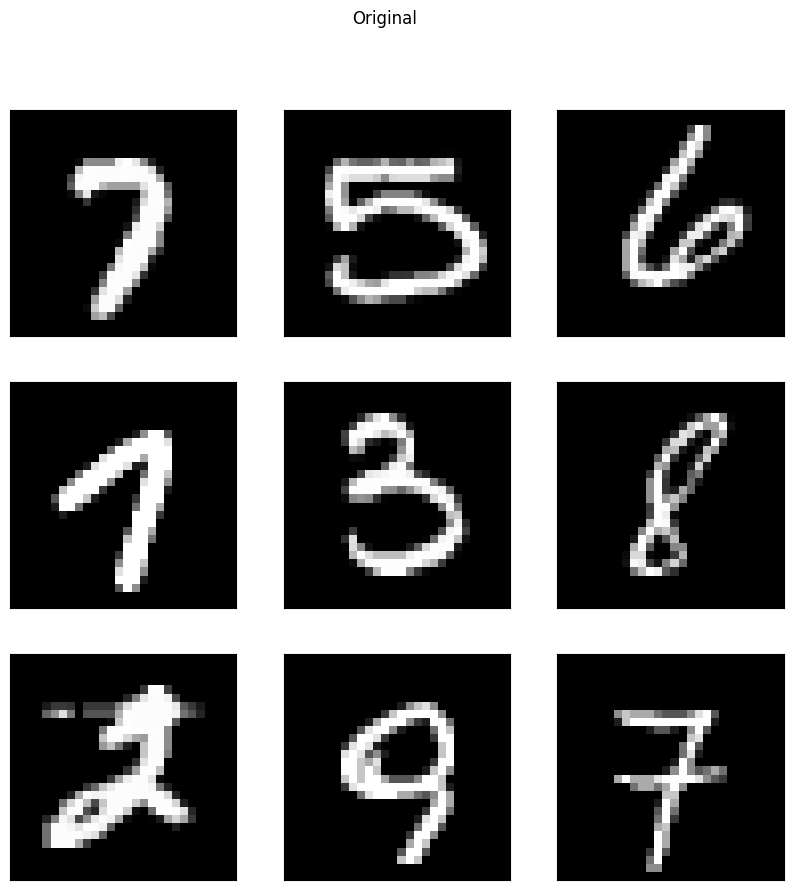

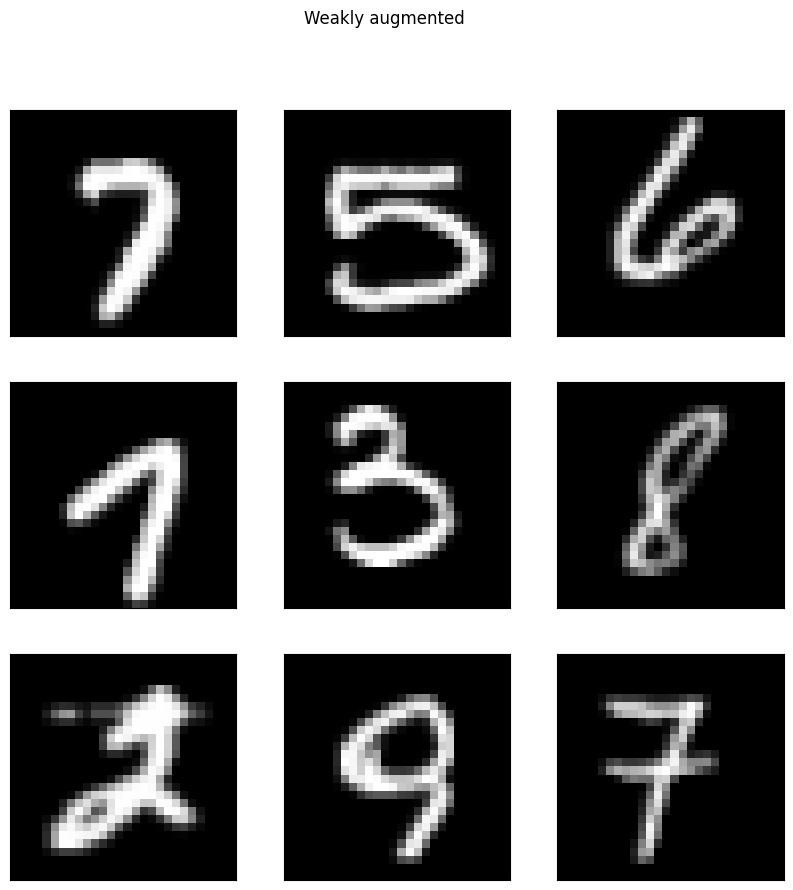

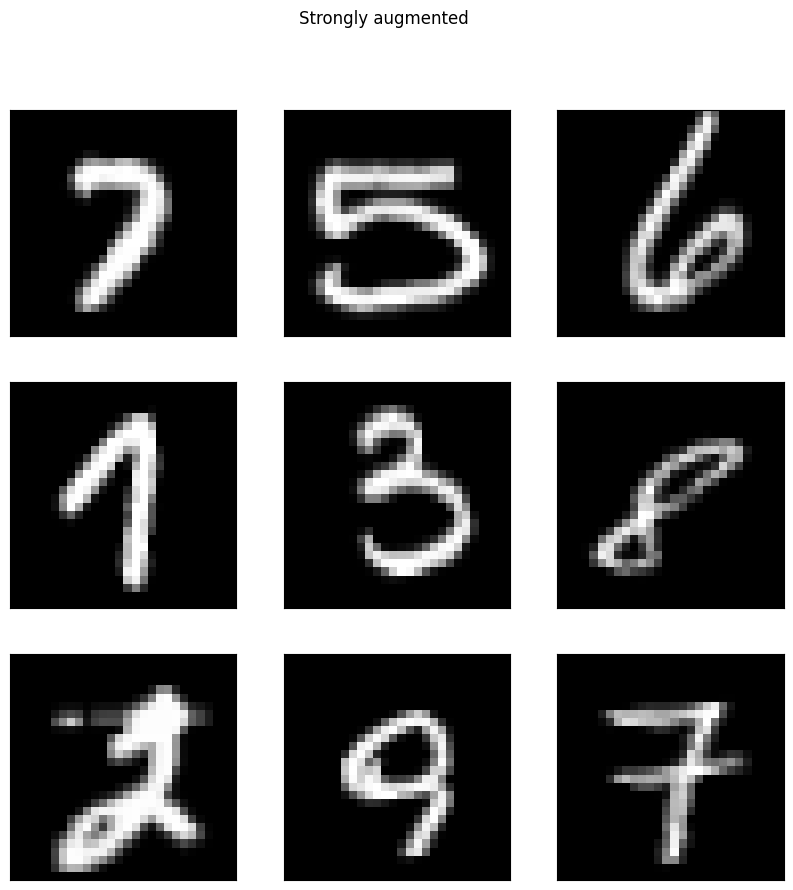

In [ ]:
# Test the augmentation
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset(num_lab = 100)

# Plot the images
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_lab[i],cmap='gray')

plt.suptitle("Original")
plt.show()

# Plot the weakly augmented images
plt.figure(figsize=(10,10))
x_aug_weak=weak_augment(x_train_lab[0:10],10)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_aug_weak[i, : ,: ,0],cmap='gray')
plt.suptitle("Weakly augmented")
plt.show()

# Plot the strongly augmented images
plt.figure(figsize=(10,10))
x_aug_strong=strong_augment(x_train_lab[0:10],10)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_aug_strong[i, : ,: ,0],cmap='gray')

plt.suptitle("Strongly augmented")
plt.show()

## Training

Fonction d'entrainement qui entraine les 4 modèles : le modèle FixMatch et les 3 modèles supervisées (différentes augmentations de données en entrée d'entrainement entre chacun) pour comparaison.

L'entrainement s'arrête soit si le nombre d'epochs surpassent le nombre définie, soit s'il n'y a aucun évolution de la loss, de l'accuracy de test ou du nombre de pseudo-label. L'évolution de ces trois paramètres se fait sur des plages : si la différence entre la moyenne des valeurs de la plage actuelle (de k à k-taille de plage) et la moyenne des valeurs de la plage précédente (de k-taille de plage-1 à k-2*(taille de plage)) est inférieur à un taux, alors on considère qu'il n'y a plus d'évolution.

La fonction prend comme paramètres :
  - Le nombre de données labélisés (par défaut 100)
  - Le nombre de données labélisés par batch. ⚠ doit être inférieur au précédent paramètre (par défaut 32)
  - La proportion de données non-labélisées utilisées par rapport aux données labélisées (nb non-lab = param * nb lab) (par défaut 7)
  - Le nombre d'epochs maximal d'entrainement (par défaut 5000)
  - Le nombre indiquant quand les performances sont affichées (afficher quand mod(epoch,param) = 0)
  - Le coefficient minimum de confiance pour qu'une donnée labélisé soit considérée comme un pseudo-label par faible augmentation (par défaut 0,99)
  - La liste des indexes dans MNIST des données sélectionnées comme données labélisées (par défaut None, donc aucune sélection)
  - Plage pour la mesure de l'évolution
  - Taux de plus d'évolution pour la loss totale
  - Taux de plus d'évolution pour l'accuracy de test
  - Taux de plus d'évolution pour le nombre de pseudo-label
  - Chemin(s) pour accéder à un modèle déjà pré-entrainé. Si plusieurs chemins pour les 4 modèles, alors liste des chemins dans l'ordre [FixMatch,Aucune augmentation,Faible Augmentation,Forte Augmentation]

La fonction enregistre lors d'amélioration de l'accuracy de test les poids et des modèles et renvoie :
  - La loss total de FixMatch pour toutes les epochs
  - La loss de la partie supervisée de FixMatch pour toutes les epochs
  - La loss des pseudo-labels de FixMatch pour toutes les epochs
  - L'accuracy d'entrainement de FixMatch pour toutes les epochs
  - L'accuracy de test de FixMatch pour toutes les epochs
  - L'accuracy d'entrainement du modèle supervisée sans augmentation pour toutes les epochs
  - L'accuracy de test du modèle supervisée sans augmentation pour toutes les epochs
  - L'accuracy d'entrainement du modèle supervisée avec faible augmentation pour toutes les epochs
  - L'accuracy de test du modèle supervisée avec faible augmentation pour toutes les epochs
  - L'accuracy d'entrainement du modèle supervisée avec forte augmentation pour toutes les epochs
  - L'accuracy de test du modèle supervisée avec forte augmentation pour toutes les epochs
  - La proportion des pseudo-labels par rapport aux données non-labélisées utilisées pour toutes les epochs
  - La proportion de pseudo-labels faux par rapport aux données non-labélisées utilisées pour toutes les epochs

In [ ]:
def train_FixMatch(num_lab=100,bs_lab=32,mu=7,epochs = 5000, show_res_every = 50, tau = 0.99, list_of_index_for_label = None,
                   average_range = 500, threshold_loss = 0.00005, threshold_acc = 0.00005, threshold_pl = 0.00005,
                   model_path = None):
    # Data
    x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_mnist_dataset(num_lab = num_lab, select_lab = list_of_index_for_label)
    if type(list_of_index_for_label).__module__ == np.__name__ or list_of_index_for_label:
      select = "_selected"
    else:
      select = ""
    # FixMatch Hyperparameters
    #mu = 7# size of unlab batch
    lambda_u = 1 # loss weight
    #tau = tau # weakly augmented threshold

    # Training parameters
    #epochs = 5000
    lr = 1e-4
    #bs_lab = 32 # lab batch size
    bs_unlab = mu * bs_lab # unlab batch size
    bs_total = bs_lab + bs_unlab # total batch size
    steps_per_epoch = math.floor(x_train_lab.shape[0]/bs_lab)
    prev_acc_FixMatch = 0
    prev_acc_noAug = 0
    prev_acc_weakAug = 0
    prev_acc_strongAug = 0

    # Logs
    train_acc_FixMatch = []
    test_acc_FixMatch = []
    train_acc_noAug = []
    test_acc_noAug = []
    train_acc_weakAug = []
    test_acc_weakAug = []
    train_acc_strongAug = []
    test_acc_strongAug = []
    losses = []
    losses_lab = []
    losses_unlab = []
    pseudo_lab = []
    false_pseudo_lab = []

    # Create model for FixMatch
    model_FixMatch = create_model_mnist()
    model_noAugment = create_model_mnist()
    model_weakAugment = create_model_mnist()
    model_strongAugment = create_model_mnist()

    if model_path:
      if len(model_path[0]) <= 1 : # Only one path (the variable is a string so the len of the first of the string is a character of len 0)
        model_FixMatch.load_weights(model_path)
      else: # If multiple path given (the variable is a list so the the first element is a string with a len > 0)
        model_FixMatch.load_weights(model_path[0])
        model_noAugment.load_weights(model_path[1])
        model_weakAugment.load_weights(model_path[2])
        model_strongAugment.load_weights(model_path[3])


    # Training settings
    optimizer_FixMatch = keras.optimizers.Adam(learning_rate=lr)
    optimizer_noAug = keras.optimizers.Adam(learning_rate=lr)
    optimizer_weakAug = keras.optimizers.Adam(learning_rate=lr)
    optimizer_strongAug = keras.optimizers.Adam(learning_rate=lr)
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

    # metrics
    train_acc_metric_FixMatch = keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric_FixMatch = keras.metrics.SparseCategoricalAccuracy()
    train_acc_metric_noAug = keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric_noAug = keras.metrics.SparseCategoricalAccuracy()
    train_acc_metric_weakAug = keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric_weakAug = keras.metrics.SparseCategoricalAccuracy()
    train_acc_metric_strongAug = keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric_strongAug = keras.metrics.SparseCategoricalAccuracy()

    # indexes
    indices_lab = np.arange(x_train_lab.shape[0]) # lab data
    indices_unlab = np.arange(x_train_unlab.shape[0]) # unlab data
    cond_out = False
    epoch = 0
    cond = ""
    # Training loop
    while (len(cond)==0):
        epoch += 1
        # Shuffle the lab data
        np.random.shuffle(indices_lab)
        # Shuffle the unlab data
        np.random.shuffle(indices_unlab)

        # Initialize cumulative losses
        cumul_loss_value = 0
        cumul_loss_value_lab = 0
        cumul_loss_value_unlab = 0
        cumul_nb_false_pl = 0

        # Intialize the number of pseudo labels
        num_pseudo_labels = 0

        # Training loop
        for step in range(steps_per_epoch):

            # Get the lab batch
            batch_indices_lab = indices_lab[step*bs_lab:(step+1)*bs_lab]
            x_batch_lab = x_train_lab[batch_indices_lab]
            y_batch_lab = y_train_lab[batch_indices_lab]

            # Get the unlab batch
            batch_indices_unlab = indices_unlab[step*bs_unlab:(step+1)*bs_unlab]
            x_batch_unlab = x_train_unlab[batch_indices_unlab]
            y_batch_unlab = y_train_unlab[batch_indices_unlab]

            # Augment labeled data
            x_batch_lab_wa = weak_augment(x_batch_lab,bs_lab)
            x_batch_lab_sa = strong_augment(x_batch_lab,bs_lab)

            # FixMatch training
            with tf.GradientTape() as tape:

              # Get predictions for the lab batch
              y_pred_lab_FixMatch = model_FixMatch(x_batch_lab_sa, training=True) #x_batch_lab_wa

              # Compute the lab loss
              loss_value_lab_FixMatch = loss_fn(y_batch_lab, y_pred_lab_FixMatch)

              # Get predictions for the unlab batch (weakly augmented)
              x_batch_unlab_wa = weak_augment(x_batch_unlab,bs_unlab)

              # Get predictions for the unlab batch (strongly augmented)
              x_batch_unlab_sa = strong_augment(x_batch_unlab,bs_unlab)
              y_pred_FixMatch_sa = model_FixMatch(x_batch_unlab_sa, training=True)

              # Compute the loss for valid pseudo labels
              pseudo_labels = create_pseudo_labels(model_FixMatch, x_batch_unlab_wa, tau)
              filtered_pseudo_labels = tf.boolean_mask(pseudo_labels, pseudo_labels != -1)
              filtered_y_pred_sa = tf.boolean_mask(y_pred_FixMatch_sa, pseudo_labels != -1)
              filtered_y_train_unlab = tf.boolean_mask(y_batch_unlab, pseudo_labels != -1)

              # Compute the loss for the unlab batch if there are valid pseudo labels
              if filtered_pseudo_labels.shape[0] > 0:
                  # print(filtered_pseudo_labels)
                  # print(filtered_y_train_unlab)

                  # print(tf.math.reduce_all(tf.math.equal(filtered_pseudo_labels,tf.cast(filtered_y_train_unlab,tf.int64))))
                  #print(filtered_pseudo_labels == tf.cast(filtered_y_train_unlab,tf.int64))
                  cumul_nb_false_pl +=  filtered_pseudo_labels.shape[0] - tf.math.count_nonzero(tf.math.equal(filtered_pseudo_labels,tf.cast(filtered_y_train_unlab,tf.int64)))
                  loss_value_unlab = loss_fn(filtered_pseudo_labels, filtered_y_pred_sa)
                  loss_value_unlab = loss_value_unlab*filtered_pseudo_labels.shape[0]/bs_lab
                  num_pseudo_labels += filtered_pseudo_labels.shape[0]
              else:
                  loss_value_unlab = 0

              # Compute the total loss
              loss_value_FixMatch = loss_value_lab_FixMatch + lambda_u * loss_value_unlab

              # Compute the gradients
              grads_FixMatch = tape.gradient(loss_value_FixMatch, model_FixMatch.trainable_weights)

              # Update the weights
              optimizer_FixMatch.apply_gradients(zip(grads_FixMatch, model_FixMatch.trainable_weights))

              # Update the cumulative loss
              cumul_loss_value += loss_value_FixMatch
              cumul_loss_value_lab += loss_value_lab_FixMatch
              cumul_loss_value_unlab += loss_value_unlab

              # Update the training accuracy
              train_acc_metric_FixMatch.update_state(np.expand_dims(y_batch_lab,1), y_pred_lab_FixMatch)

            # Complete learning without augmentation training
            with tf.GradientTape() as tape:

              # Get predictions for the lab batch
              y_pred_lab_noAug = model_noAugment(x_batch_lab, training=True)

              # Compute the lab loss
              loss_value_lab_noAug = loss_fn(y_batch_lab, y_pred_lab_noAug)

              # Compute the gradients
              grads_noAug = tape.gradient(loss_value_lab_noAug, model_noAugment.trainable_weights)

              # Update the weights
              optimizer_noAug.apply_gradients(zip(grads_noAug, model_noAugment.trainable_weights))

              # Update the training accuracy
              train_acc_metric_noAug.update_state(np.expand_dims(y_batch_lab,1), y_pred_lab_noAug)

            # Complete learning with weak augmentation training
            with tf.GradientTape() as tape:

              # Get predictions for the lab batch
              y_pred_lab_weakAug = model_weakAugment(x_batch_lab_wa, training=True)

              # Compute the lab loss
              loss_value_lab_weakAug = loss_fn(y_batch_lab, y_pred_lab_weakAug)

              # Compute the gradients
              grads_weakAug = tape.gradient(loss_value_lab_weakAug, model_weakAugment.trainable_weights)

              # Update the weights
              optimizer_weakAug.apply_gradients(zip(grads_weakAug, model_weakAugment.trainable_weights))

              # Update the training accuracy
              train_acc_metric_weakAug.update_state(np.expand_dims(y_batch_lab,1), y_pred_lab_weakAug)

            # Complete learning with strong augmentation training
            with tf.GradientTape() as tape:

              # Get predictions for the lab batch
              y_pred_lab_strongAug = model_strongAugment(x_batch_lab_sa, training=True)

              # Compute the lab loss
              loss_value_lab_strongAug = loss_fn(y_batch_lab, y_pred_lab_strongAug)

              # Compute the gradients
              grads_strongAug = tape.gradient(loss_value_lab_strongAug, model_strongAugment.trainable_weights)

              # Update the weights
              optimizer_strongAug.apply_gradients(zip(grads_strongAug, model_strongAugment.trainable_weights))

              # Update the training accuracy
              train_acc_metric_strongAug.update_state(np.expand_dims(y_batch_lab,1), y_pred_lab_strongAug)

        cumul_loss_value = cumul_loss_value / steps_per_epoch
        cumul_loss_value_lab = cumul_loss_value_lab / steps_per_epoch
        cumul_loss_value_unlab = cumul_loss_value_unlab / steps_per_epoch

        # Calculate the average pseudo labels
        num_pseudo_labels = num_pseudo_labels / (steps_per_epoch*bs_unlab)
        num_false_pseudo_labels = cumul_nb_false_pl/(steps_per_epoch*bs_unlab)

        # Calculate the average training accuracy
        avg_train_acc_FixMatch = train_acc_metric_FixMatch.result()
        avg_train_acc_noAug = train_acc_metric_noAug.result()
        avg_train_acc_weakAug = train_acc_metric_weakAug.result()
        avg_train_acc_strongAug = train_acc_metric_strongAug.result()

        # Reset the training metrics
        train_acc_metric_FixMatch.reset_states()
        train_acc_metric_noAug.reset_states()
        train_acc_metric_weakAug.reset_states()
        train_acc_metric_strongAug.reset_states()

        # Calculate the test accuracy
        # Evaluate the model on the test data without using 'evaluate'
        test_acc_metric_FixMatch.update_state(np.expand_dims(y_test,1), model_FixMatch(x_test, training=False))
        test_acc_metric_noAug.update_state(np.expand_dims(y_test,1), model_noAugment(x_test, training=False))
        test_acc_metric_weakAug.update_state(np.expand_dims(y_test,1), model_weakAugment(x_test, training=False))
        test_acc_metric_strongAug.update_state(np.expand_dims(y_test,1), model_strongAugment(x_test, training=False))

        # Calculate the average test accuracy
        avg_test_acc_FixMatch = test_acc_metric_FixMatch.result().numpy()
        avg_test_acc_noAug = test_acc_metric_noAug.result().numpy()
        avg_test_acc_weakAug = test_acc_metric_weakAug.result().numpy()
        avg_test_acc_strongAug = test_acc_metric_strongAug.result().numpy()

        # if the test accuracy is better than the previous one, save the model
        if avg_test_acc_FixMatch > prev_acc_FixMatch:
          if model_path:
            if len(model_path[0]) <= 1:
              model_FixMatch.save_weights(model_path)
            else:
              model_FixMatch.save_weights(model_path[0])
          else:
            model_FixMatch.save_weights(f'model_{num_lab}_{tau}{select}_FixMatch.h5')
          prev_acc_FixMatch = avg_test_acc_FixMatch

        if avg_test_acc_noAug > prev_acc_noAug:
          if model_path and not(len(model_path[0]) <= 1):
            model_noAugment.save_weights(model_path[1])
          else:
            model_noAugment.save_weights(f'model_{num_lab}_{tau}{select}_noAug.h5')
          prev_acc_noAug = avg_test_acc_noAug

        if avg_test_acc_weakAug > prev_acc_weakAug:
          if model_path and not(len(model_path[0]) <= 1):
            model_weakAugment.save_weights(model_path[2])
          else:
            model_weakAugment.save_weights(f'model_{num_lab}_{tau}{select}_weakAug.h5')
          prev_acc_weakAug = avg_test_acc_weakAug

        if avg_test_acc_strongAug > prev_acc_strongAug:
          if model_path and not(len(model_path[0]) <= 1):
            model_strongAugment.save_weights(model_path[3])
          else:
            model_strongAugment.save_weights(f'model_{num_lab}_{tau}{select}_strongAug.h5')
          prev_acc_strongAug = avg_test_acc_strongAug

        # Reset the test metrics
        test_acc_metric_FixMatch.reset_states()
        test_acc_metric_noAug.reset_states()
        test_acc_metric_weakAug.reset_states()
        test_acc_metric_strongAug.reset_states()

        # Save the results
        losses.append(cumul_loss_value)
        losses_lab.append(cumul_loss_value_lab)
        losses_unlab.append(cumul_loss_value_unlab)
        train_acc_FixMatch.append(avg_train_acc_FixMatch)
        test_acc_FixMatch.append(avg_test_acc_FixMatch)
        train_acc_noAug.append(avg_train_acc_noAug)
        test_acc_noAug.append(avg_test_acc_noAug)
        train_acc_weakAug.append(avg_train_acc_weakAug)
        test_acc_weakAug.append(avg_test_acc_weakAug)
        train_acc_strongAug.append(avg_train_acc_strongAug)
        test_acc_strongAug.append(avg_test_acc_strongAug)
        pseudo_lab.append(num_pseudo_labels)
        false_pseudo_lab.append(num_false_pseudo_labels)

        if (epoch%show_res_every==0):
            # Print the results
            print('Epoch: {}, Loss: {}, Loss lab: {}, Loss unlab: {}, Train Accuracy: {}, Test Accuracy: {}, Pseudo Labels: {}, Wrong Pseudo Labels {}'.format(
                epoch, cumul_loss_value, cumul_loss_value_lab, cumul_loss_value_unlab, avg_train_acc_FixMatch, avg_test_acc_FixMatch, num_pseudo_labels,num_false_pseudo_labels))

        if epochs <= epoch:
          cond = "epoch"
        elif abs( (sum(losses[len(losses)-2*average_range:len(losses)-average_range]) - sum(losses[len(losses)-average_range:]) ) / average_range) < threshold_loss and epoch > average_range * 2:
          cond = "loss"
        elif abs( (sum(test_acc_FixMatch[len(test_acc_FixMatch)-2*average_range:len(test_acc_FixMatch)-average_range]) - sum(test_acc_FixMatch[len(test_acc_FixMatch)-average_range:]) ) / average_range) < threshold_acc and epoch > average_range * 2:
          cond = "accuracy"
        elif abs( (sum(pseudo_lab[len(pseudo_lab)-2*average_range:len(pseudo_lab)-average_range]) - sum(pseudo_lab[len(pseudo_lab)-average_range:]) ) / average_range) < threshold_pl and epoch > average_range * 2:
          cond = "pseudo-label"

    return [losses,losses_lab,losses_unlab,train_acc_FixMatch,test_acc_FixMatch,train_acc_noAug,test_acc_noAug,train_acc_weakAug,test_acc_weakAug,train_acc_strongAug,test_acc_strongAug,pseudo_lab,false_pseudo_lab,cond]

## Experience random labels

Entrainements pour différents nombre de données labélisées puis affichage et enregistrement des résultats

### 100 labels

In [ ]:
[losses_100,losses_lab_100,losses_unlab_100,
 train_acc_FixMatch_100,test_acc_FixMatch_100,
 train_acc_noAug_100,test_acc_noAug_100,
 train_acc_weakAug_100,test_acc_weakAug_100,
 train_acc_strongAug_100,test_acc_strongAug_100,
 pseudo_lab_100,false_pseudo_lab_100,cond_out_100] = train_FixMatch(100,32,7,10000, 250, threshold_acc=0,threshold_loss=0,threshold_pl=0)


Epoch: 250, Loss: 0.6466121077537537, Loss lab: 0.5074679255485535, Loss unlab: 0.13914424180984497, Train Accuracy: 0.84375, Test Accuracy: 0.8360999822616577, Pseudo Labels: 0.06547619047619048, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.3282386362552643, Loss lab: 0.20266449451446533, Loss unlab: 0.12557412683963776, Train Accuracy: 0.9270833134651184, Test Accuracy: 0.8855999708175659, Pseudo Labels: 0.3020833333333333, Wrong Pseudo Labels 0.005952380952380952
Epoch: 750, Loss: 0.3099694550037384, Loss lab: 0.07038002461194992, Loss unlab: 0.23958943784236908, Train Accuracy: 1.0, Test Accuracy: 0.9065999984741211, Pseudo Labels: 0.47619047619047616, Wrong Pseudo Labels 0.004464285714285714
Epoch: 1000, Loss: 0.30238670110702515, Loss lab: 0.06457694619894028, Loss unlab: 0.23780973255634308, Train Accuracy: 0.9895833134651184, Test Accuracy: 0.9297000169754028, Pseudo Labels: 0.5773809523809523, Wrong Pseudo Labels 0.00744047619047619
Epoch: 1250, Loss: 0.26163962483406067, Loss 

Condition of stopping : epoch


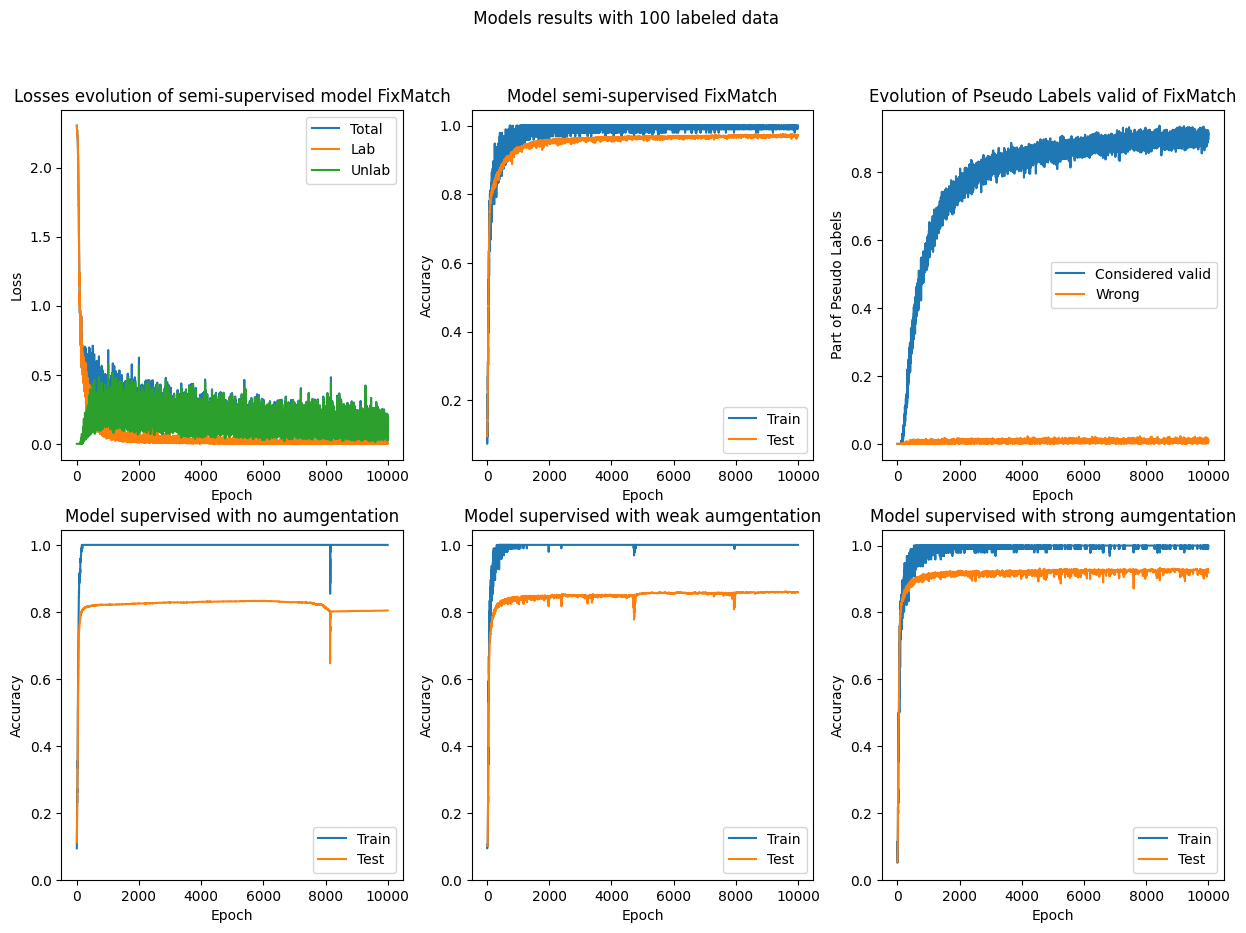

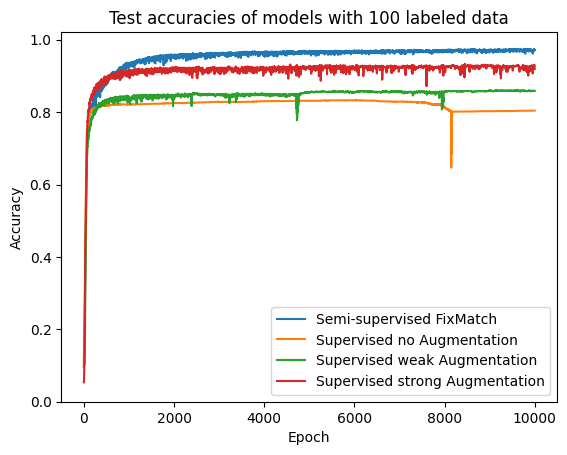

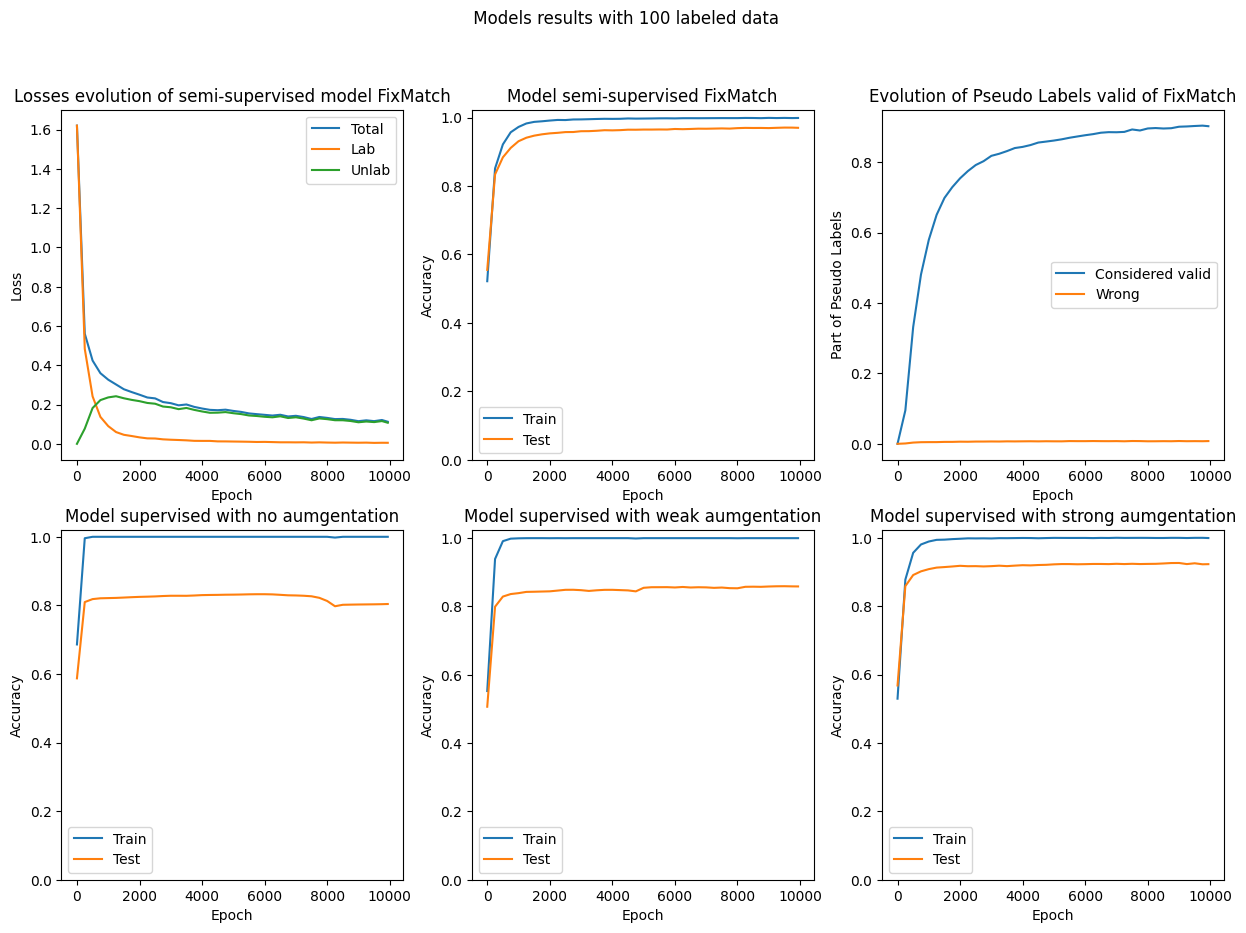

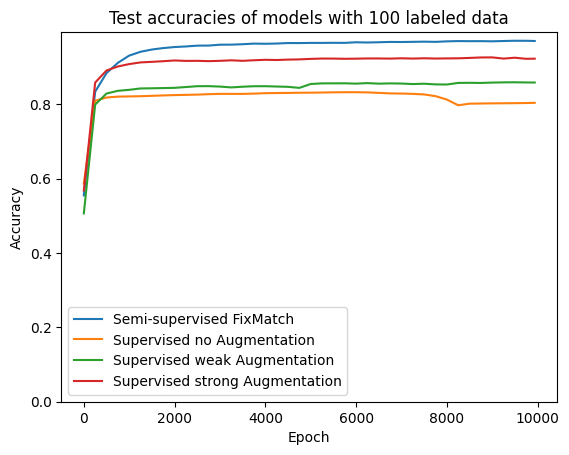

In [ ]:
print(f"Condition of stopping : {cond_out_100}")
draw_results_raw(losses_100,losses_lab_100,losses_unlab_100,
 train_acc_FixMatch_100,test_acc_FixMatch_100,
 train_acc_noAug_100,test_acc_noAug_100,
 train_acc_weakAug_100,test_acc_weakAug_100,
 train_acc_strongAug_100,test_acc_strongAug_100,
 pseudo_lab_100,false_pseudo_lab_100,100)
# Affichage bruités et difficile à lire à cause de l'aléatoire donc affichage avec moyennes sur des plages.
draw_results_smooth(losses_100,losses_lab_100,losses_unlab_100,
 train_acc_FixMatch_100,test_acc_FixMatch_100,
 train_acc_noAug_100,test_acc_noAug_100,
 train_acc_weakAug_100,test_acc_weakAug_100,
 train_acc_strongAug_100,test_acc_strongAug_100,
 pseudo_lab_100,false_pseudo_lab_100,100)

In [ ]:
save_results(losses_100,losses_lab_100,losses_unlab_100,
 train_acc_FixMatch_100,test_acc_FixMatch_100,
 train_acc_noAug_100,test_acc_noAug_100,
 train_acc_weakAug_100,test_acc_weakAug_100,
 train_acc_strongAug_100,test_acc_strongAug_100,
 pseudo_lab_100,false_pseudo_lab_100,100)

### 50 labels

In [ ]:
[losses_50,losses_lab_50,losses_unlab_50,
 train_acc_FixMatch_50,test_acc_FixMatch_50,
 train_acc_noAug_50,test_acc_noAug_50,
 train_acc_weakAug_50,test_acc_weakAug_50,
 train_acc_strongAug_50,test_acc_strongAug_50,
 pseudo_lab_50,false_pseudo_lab_50,cond_out_50] = train_FixMatch(50,32,7,10000, 250, threshold_acc=0,threshold_loss=0,threshold_pl=0)

Epoch: 250, Loss: 0.9555423855781555, Loss lab: 0.9555423855781555, Loss unlab: 0.0, Train Accuracy: 0.84375, Test Accuracy: 0.7324000000953674, Pseudo Labels: 0.0, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.509406328201294, Loss lab: 0.496972918510437, Loss unlab: 0.01243341900408268, Train Accuracy: 0.875, Test Accuracy: 0.7646999955177307, Pseudo Labels: 0.026785714285714284, Wrong Pseudo Labels 0.0
Epoch: 750, Loss: 0.5099027156829834, Loss lab: 0.2791270315647125, Loss unlab: 0.23077571392059326, Train Accuracy: 0.90625, Test Accuracy: 0.7850000262260437, Pseudo Labels: 0.16071428571428573, Wrong Pseudo Labels 0.004464285714285714
Epoch: 1000, Loss: 0.5587596893310547, Loss lab: 0.13160839676856995, Loss unlab: 0.42715132236480713, Train Accuracy: 0.96875, Test Accuracy: 0.8030999898910522, Pseudo Labels: 0.3125, Wrong Pseudo Labels 0.013392857142857142
Epoch: 1250, Loss: 0.38094156980514526, Loss lab: 0.1590448021888733, Loss unlab: 0.22189675271511078, Train Accuracy: 0.9375, T

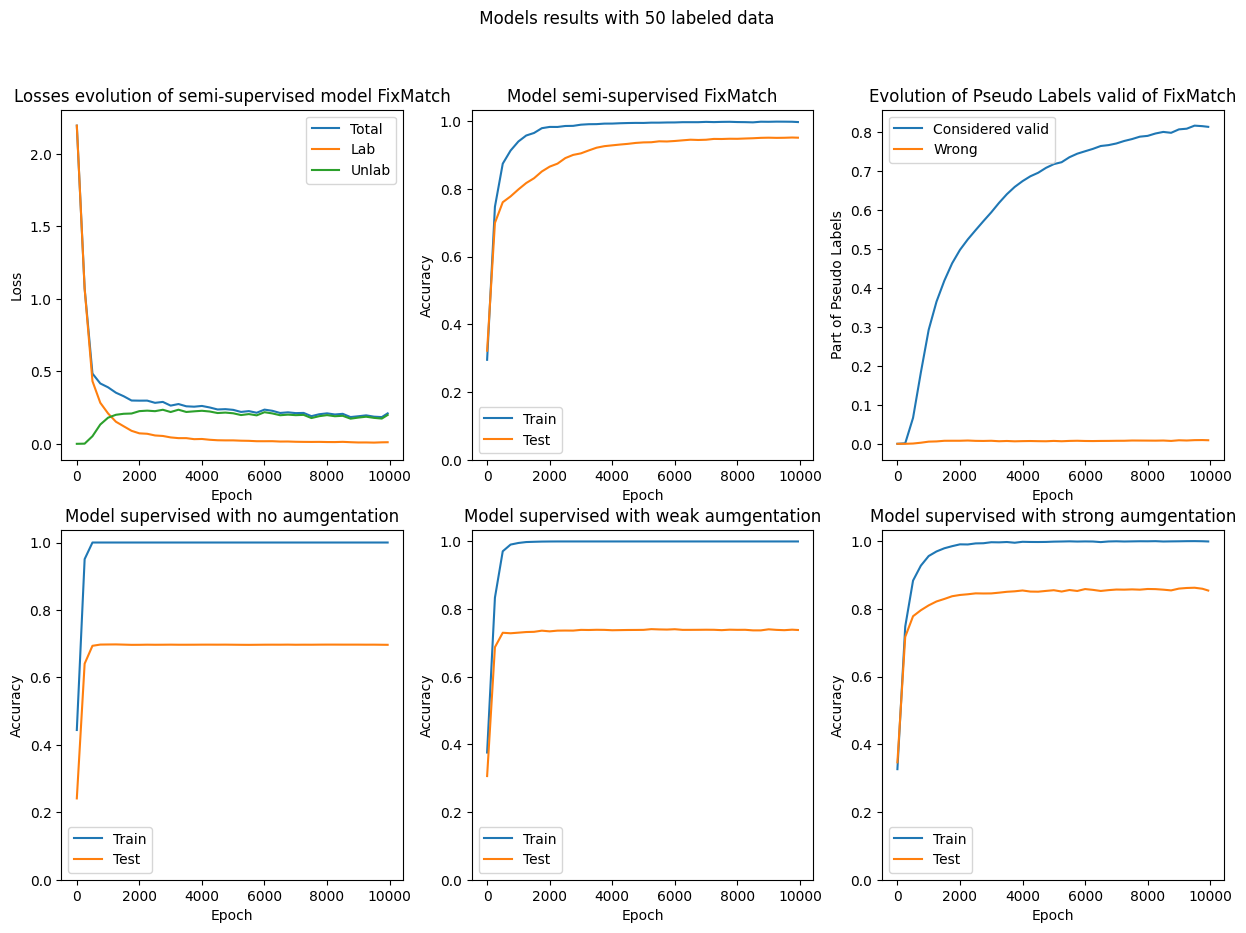

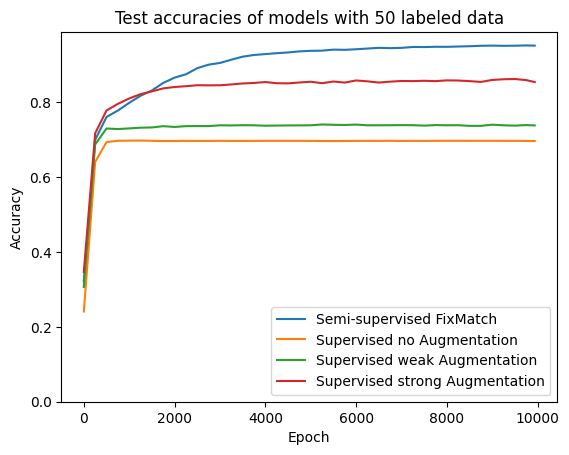

In [ ]:
draw_results_smooth(losses_50,losses_lab_50,losses_unlab_50,
 train_acc_FixMatch_50,test_acc_FixMatch_50,
 train_acc_noAug_50,test_acc_noAug_50,
 train_acc_weakAug_50,test_acc_weakAug_50,
 train_acc_strongAug_50,test_acc_strongAug_50,
 pseudo_lab_50,false_pseudo_lab_50,50)
save_results(losses_50,losses_lab_50,losses_unlab_50,
 train_acc_FixMatch_50,test_acc_FixMatch_50,
 train_acc_noAug_50,test_acc_noAug_50,
 train_acc_weakAug_50,test_acc_weakAug_50,
 train_acc_strongAug_50,test_acc_strongAug_50,
 pseudo_lab_50,false_pseudo_lab_50,50)

### 10 labels

In [ ]:
[losses_10,losses_lab_10,losses_unlab_10,
 train_acc_FixMatch_10,test_acc_FixMatch_10,
 train_acc_noAug_10,test_acc_noAug_10,
 train_acc_weakAug_10,test_acc_weakAug_10,
 train_acc_strongAug_10,test_acc_strongAug_10,
 pseudo_lab_10,false_pseudo_lab_10,cond_out_10] = train_FixMatch(10,10,7,10000, 250, threshold_acc=0,threshold_loss=0,threshold_pl=0)

Epoch: 250, Loss: 0.5939518213272095, Loss lab: 0.5939518213272095, Loss unlab: 0.0, Train Accuracy: 0.8999999761581421, Test Accuracy: 0.5074999928474426, Pseudo Labels: 0.0, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.16436977684497833, Loss lab: 0.16173459589481354, Loss unlab: 0.002635182114318013, Train Accuracy: 0.8999999761581421, Test Accuracy: 0.5274999737739563, Pseudo Labels: 0.07142857142857142, Wrong Pseudo Labels 0.0
Epoch: 750, Loss: 0.2544272541999817, Loss lab: 0.07625304162502289, Loss unlab: 0.17817422747612, Train Accuracy: 1.0, Test Accuracy: 0.5773000121116638, Pseudo Labels: 0.15714285714285714, Wrong Pseudo Labels 0.0
Epoch: 1000, Loss: 0.09649398922920227, Loss lab: 0.01837938465178013, Loss unlab: 0.07811460644006729, Train Accuracy: 1.0, Test Accuracy: 0.5999000072479248, Pseudo Labels: 0.3, Wrong Pseudo Labels 0.0
Epoch: 1250, Loss: 0.3685758709907532, Loss lab: 0.030256623402237892, Loss unlab: 0.33831924200057983, Train Accuracy: 1.0, Test Accuracy: 0.6075

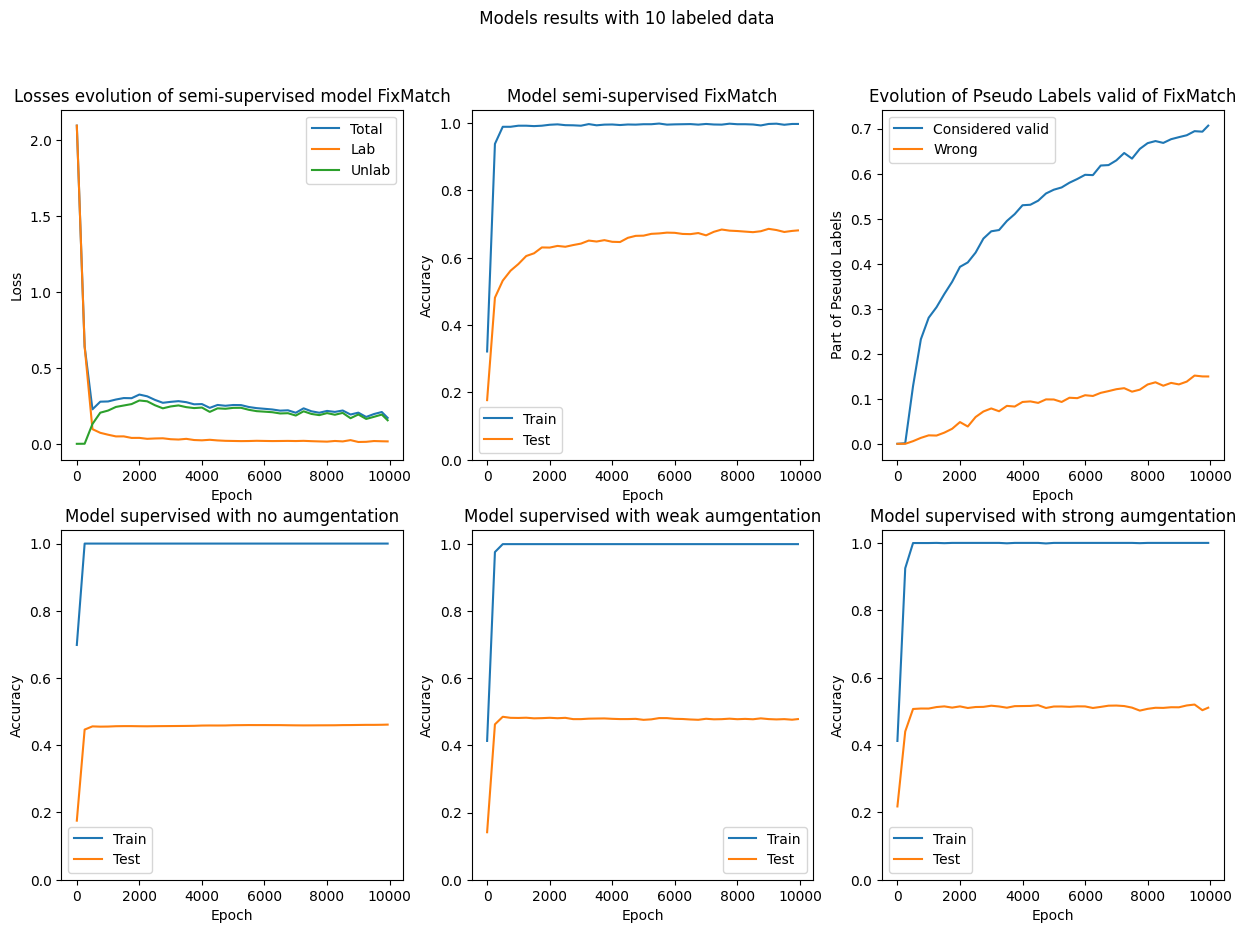

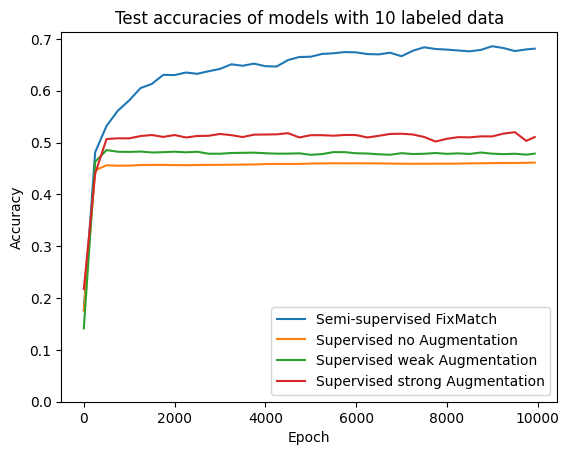

In [ ]:
draw_results_smooth(losses_10,losses_lab_10,losses_unlab_10,
 train_acc_FixMatch_10,test_acc_FixMatch_10,
 train_acc_noAug_10,test_acc_noAug_10,
 train_acc_weakAug_10,test_acc_weakAug_10,
 train_acc_strongAug_10,test_acc_strongAug_10,
 pseudo_lab_10,false_pseudo_lab_10,"10")
save_results(losses_10,losses_lab_10,losses_unlab_10,
 train_acc_FixMatch_10,test_acc_FixMatch_10,
 train_acc_noAug_10,test_acc_noAug_10,
 train_acc_weakAug_10,test_acc_weakAug_10,
 train_acc_strongAug_10,test_acc_strongAug_10,
 pseudo_lab_10,false_pseudo_lab_10,"10")

## Experiences selected labels

Entrainements avec les données labélisées sélectionnées puis affichage et enregistrement des résultats

### 100 labels selected by strong augmentation

In [ ]:
index_s_100 = load_labels_indexes("top_10_indices_aug_strong.csv")
[losses_100_select_s,losses_lab_100_select_s,losses_unlab_100_select_s,
 train_acc_FixMatch_100_select_s,test_acc_FixMatch_100_select_s,
 train_acc_noAug_100_select_s,test_acc_noAug_100_select_s,
 train_acc_weakAug_100_select_s,test_acc_weakAug_100_select_s,
 train_acc_strongAug_100_select_s,test_acc_strongAug_100_select_s,
 pseudo_lab_100_select_s,false_pseudo_lab_100_select_s,cond_out_100_select_s] = train_FixMatch(100,32,7,10000, 250, list_of_index_for_label=index_s_100, threshold_loss= 0, threshold_acc= 0, threshold_pl= 0)

Epoch: 250, Loss: 0.42635273933410645, Loss lab: 0.13846151530742645, Loss unlab: 0.2878912389278412, Train Accuracy: 0.96875, Test Accuracy: 0.8274999856948853, Pseudo Labels: 0.28125, Wrong Pseudo Labels 0.010416666666666666
Epoch: 500, Loss: 0.24525773525238037, Loss lab: 0.07726158946752548, Loss unlab: 0.16799615323543549, Train Accuracy: 0.96875, Test Accuracy: 0.885699987411499, Pseudo Labels: 0.39732142857142855, Wrong Pseudo Labels 0.002976190476190476
Epoch: 750, Loss: 0.18113595247268677, Loss lab: 0.018512628972530365, Loss unlab: 0.162623330950737, Train Accuracy: 1.0, Test Accuracy: 0.911300003528595, Pseudo Labels: 0.5223214285714286, Wrong Pseudo Labels 0.002976190476190476
Epoch: 1000, Loss: 0.1798737794160843, Loss lab: 0.011949419975280762, Loss unlab: 0.16792435944080353, Train Accuracy: 1.0, Test Accuracy: 0.9297999739646912, Pseudo Labels: 0.5491071428571429, Wrong Pseudo Labels 0.005952380952380952
Epoch: 1250, Loss: 0.14311674237251282, Loss lab: 0.0326024927198

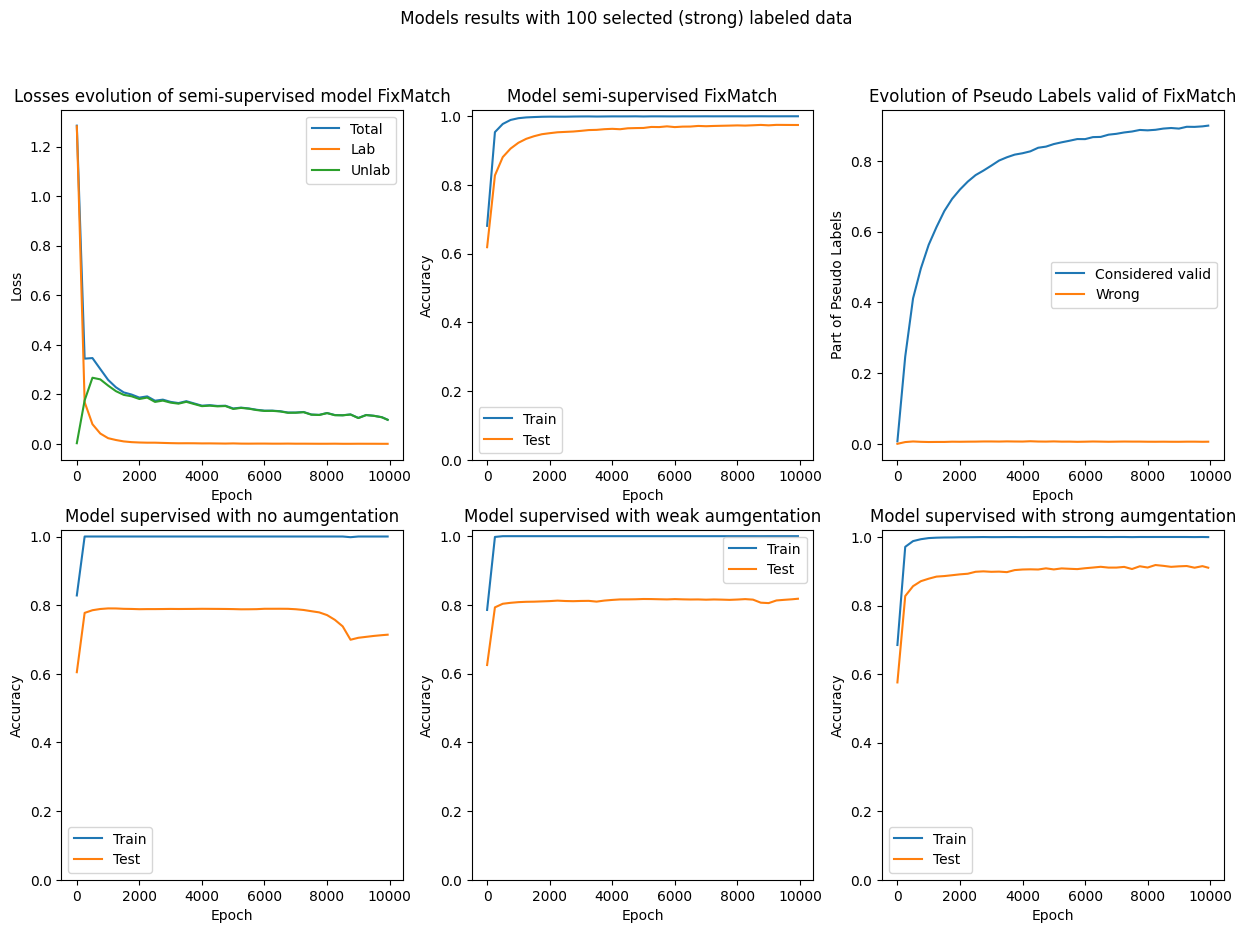

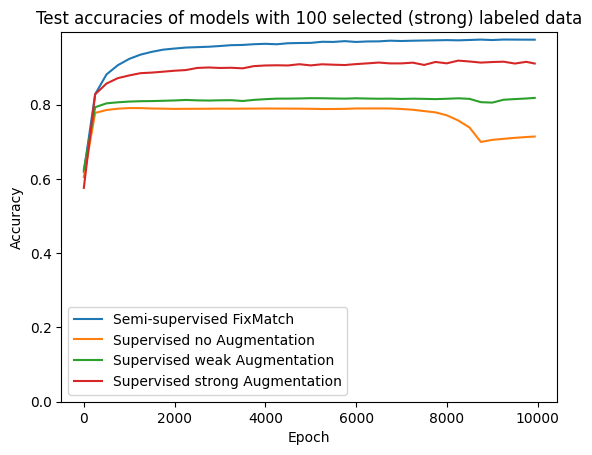

In [ ]:
draw_results_smooth(losses_100_select_s,losses_lab_100_select_s,losses_unlab_100_select_s,
 train_acc_FixMatch_100_select_s,test_acc_FixMatch_100_select_s,
 train_acc_noAug_100_select_s,test_acc_noAug_100_select_s,
 train_acc_weakAug_100_select_s,test_acc_weakAug_100_select_s,
 train_acc_strongAug_100_select_s,test_acc_strongAug_100_select_s,
 pseudo_lab_100_select_s,false_pseudo_lab_100_select_s,"100 selected (strong)")
save_results(losses_100_select_s,losses_lab_100_select_s,losses_unlab_100_select_s,
 train_acc_FixMatch_100_select_s,test_acc_FixMatch_100_select_s,
 train_acc_noAug_100_select_s,test_acc_noAug_100_select_s,
 train_acc_weakAug_100_select_s,test_acc_weakAug_100_select_s,
 train_acc_strongAug_100_select_s,test_acc_strongAug_100_select_s,
 pseudo_lab_100_select_s,false_pseudo_lab_100_select_s,"100 selected (strong)")

### 50 labels selected by strong augmentation

In [ ]:
index_s_50 = load_labels_indexes("top_5_indices_aug_strong.csv")
[losses_50_select_s,losses_lab_50_select_s,losses_unlab_50_select_s,
 train_acc_FixMatch_50_select_s,test_acc_FixMatch_50_select_s,
 train_acc_noAug_50_select_s,test_acc_noAug_50_select_s,
 train_acc_weakAug_50_select_s,test_acc_weakAug_50_select_s,
 train_acc_strongAug_50_select_s,test_acc_strongAug_50_select_s,
 pseudo_lab_50_select_s,false_pseudo_lab_50_select_s,cond_out_50_select_s] = train_FixMatch(50,32,7,10000, 250, list_of_index_for_label=index_s_50, threshold_loss= 0, threshold_acc= 0, threshold_pl= 0)

Epoch: 250, Loss: 0.2742787301540375, Loss lab: 0.2742787301540375, Loss unlab: 0.0, Train Accuracy: 0.96875, Test Accuracy: 0.7387999892234802, Pseudo Labels: 0.0, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.23498407006263733, Loss lab: 0.16966906189918518, Loss unlab: 0.06531500071287155, Train Accuracy: 0.9375, Test Accuracy: 0.7888000011444092, Pseudo Labels: 0.12946428571428573, Wrong Pseudo Labels 0.004464285714285714
Epoch: 750, Loss: 0.22220680117607117, Loss lab: 0.13850393891334534, Loss unlab: 0.08370285481214523, Train Accuracy: 0.96875, Test Accuracy: 0.8026000261306763, Pseudo Labels: 0.32589285714285715, Wrong Pseudo Labels 0.0
Epoch: 1000, Loss: 0.15563572943210602, Loss lab: 0.03691234812140465, Loss unlab: 0.11872337758541107, Train Accuracy: 1.0, Test Accuracy: 0.8136000037193298, Pseudo Labels: 0.39285714285714285, Wrong Pseudo Labels 0.008928571428571428
Epoch: 1250, Loss: 0.3363487422466278, Loss lab: 0.02144916169345379, Loss unlab: 0.31489959359169006, Train Acc

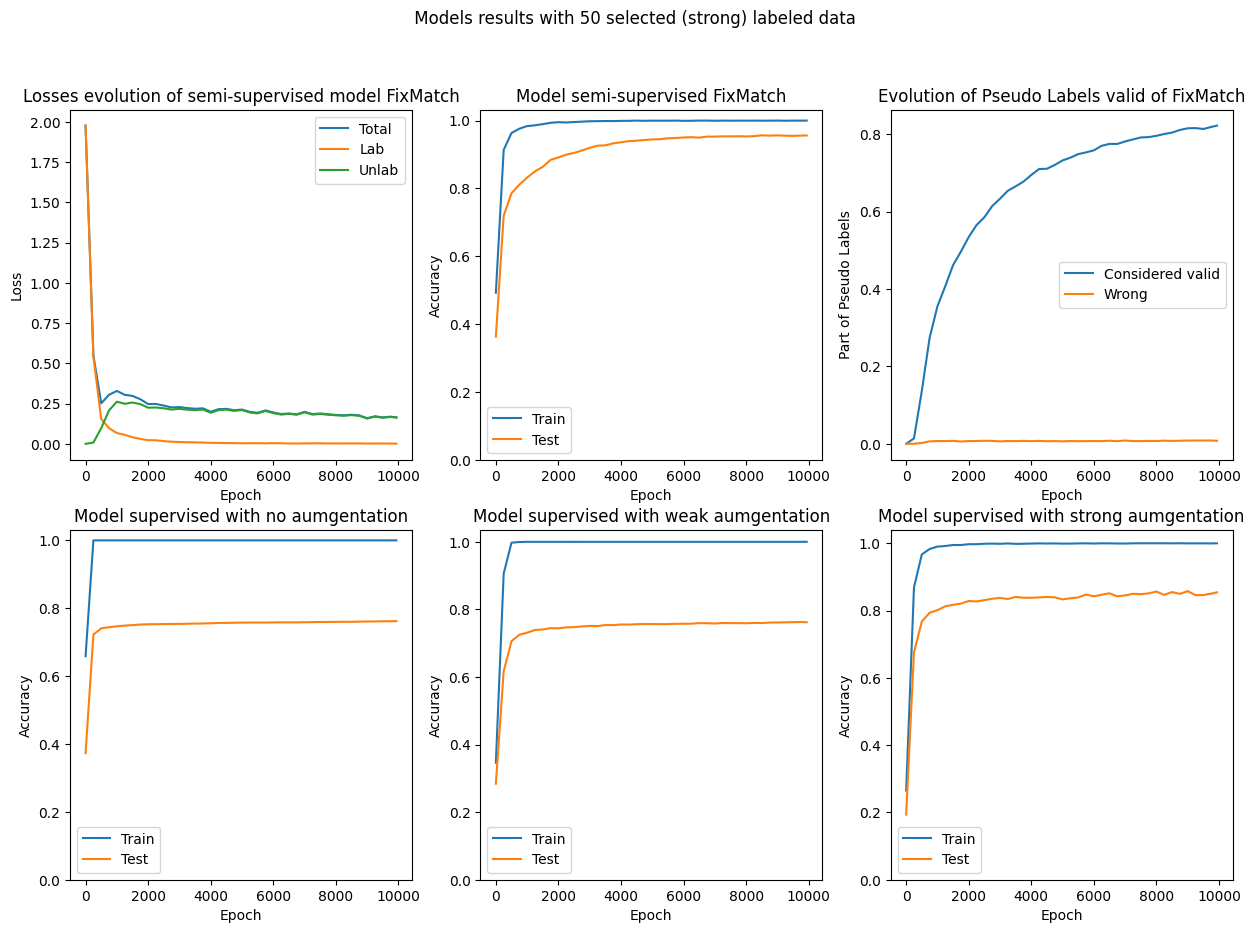

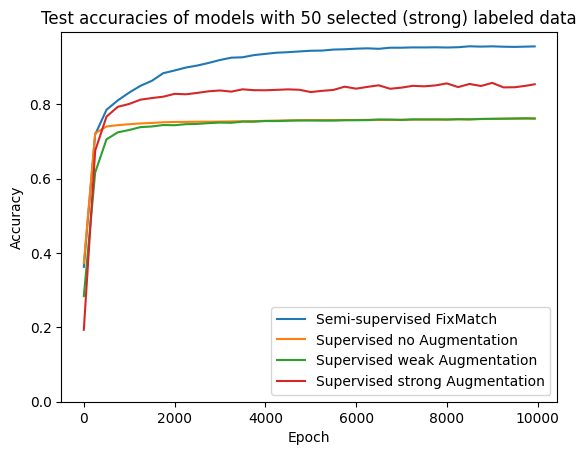

In [ ]:
draw_results_smooth(losses_50_select_s,losses_lab_50_select_s,losses_unlab_50_select_s,
 train_acc_FixMatch_50_select_s,test_acc_FixMatch_50_select_s,
 train_acc_noAug_50_select_s,test_acc_noAug_50_select_s,
 train_acc_weakAug_50_select_s,test_acc_weakAug_50_select_s,
 train_acc_strongAug_50_select_s,test_acc_strongAug_50_select_s,
 pseudo_lab_50_select_s,false_pseudo_lab_50_select_s,"50 selected (strong)")
save_results(losses_50_select_s,losses_lab_50_select_s,losses_unlab_50_select_s,
 train_acc_FixMatch_50_select_s,test_acc_FixMatch_50_select_s,
 train_acc_noAug_50_select_s,test_acc_noAug_50_select_s,
 train_acc_weakAug_50_select_s,test_acc_weakAug_50_select_s,
 train_acc_strongAug_50_select_s,test_acc_strongAug_50_select_s,
 pseudo_lab_50_select_s,false_pseudo_lab_50_select_s,"50 selected (strong)")

### 50 labels selected by weak augmentation

In [ ]:
index_w_50 = load_labels_indexes("top_5_indices_aug_weak.csv")
[losses_50_select_w,losses_lab_50_select_w,losses_unlab_50_select_w,
 train_acc_FixMatch_50_select_w,test_acc_FixMatch_50_select_w,
 train_acc_noAug_50_select_w,test_acc_noAug_50_select_w,
 train_acc_weakAug_50_select_w,test_acc_weakAug_50_select_w,
 train_acc_strongAug_50_select_w,test_acc_strongAug_50_selectw,
 pseudo_lab_50_select_w,false_pseudo_lab_50_select_w,cond_out_50_select_w] = train_FixMatch(50,32,7,10000, 250, list_of_index_for_label=index_w_50, threshold_loss= 0, threshold_acc= 0, threshold_pl= 0)

Epoch: 250, Loss: 0.7334007024765015, Loss lab: 0.7334007024765015, Loss unlab: 0.0, Train Accuracy: 0.84375, Test Accuracy: 0.7085999846458435, Pseudo Labels: 0.0, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.20462599396705627, Loss lab: 0.17923998832702637, Loss unlab: 0.025386011227965355, Train Accuracy: 1.0, Test Accuracy: 0.805400013923645, Pseudo Labels: 0.10267857142857142, Wrong Pseudo Labels 0.0
Epoch: 750, Loss: 0.258048951625824, Loss lab: 0.18252794444561005, Loss unlab: 0.07552100718021393, Train Accuracy: 0.9375, Test Accuracy: 0.8245999813079834, Pseudo Labels: 0.22767857142857142, Wrong Pseudo Labels 0.0
Epoch: 1000, Loss: 0.18507444858551025, Loss lab: 0.055753983557224274, Loss unlab: 0.12932047247886658, Train Accuracy: 1.0, Test Accuracy: 0.8468000292778015, Pseudo Labels: 0.41517857142857145, Wrong Pseudo Labels 0.0
Epoch: 1250, Loss: 0.17471028864383698, Loss lab: 0.02247336506843567, Loss unlab: 0.1522369235754013, Train Accuracy: 1.0, Test Accuracy: 0.8740000128

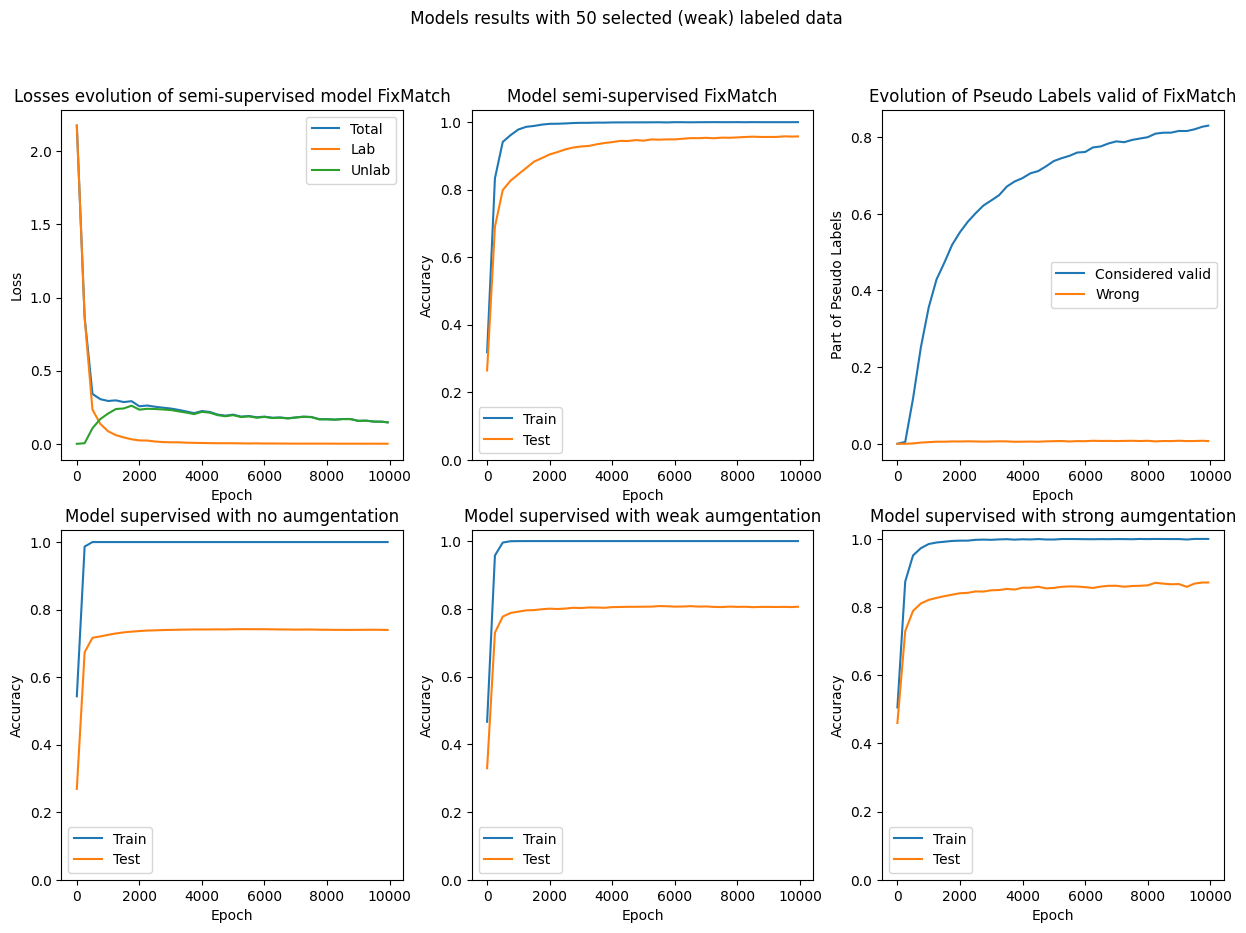

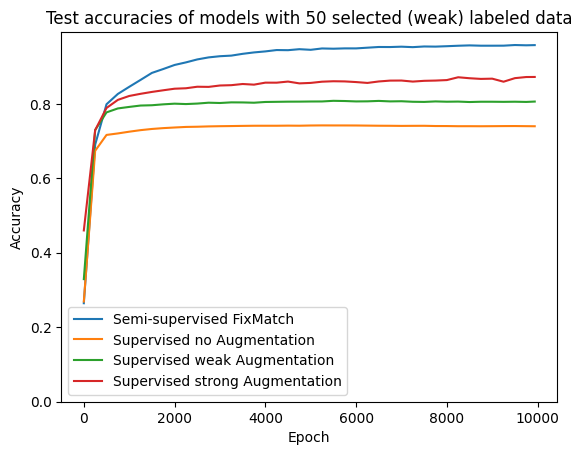

In [ ]:
draw_results_smooth(losses_50_select_w,losses_lab_50_select_w,losses_unlab_50_select_w,
 train_acc_FixMatch_50_select_w,test_acc_FixMatch_50_select_w,
 train_acc_noAug_50_select_w,test_acc_noAug_50_select_w,
 train_acc_weakAug_50_select_w,test_acc_weakAug_50_select_w,
 train_acc_strongAug_50_select_w,test_acc_strongAug_50_selectw,
 pseudo_lab_50_select_w,false_pseudo_lab_50_select_w,"50 selected (weak)")
save_results(losses_50_select_w,losses_lab_50_select_w,losses_unlab_50_select_w,
 train_acc_FixMatch_50_select_w,test_acc_FixMatch_50_select_w,
 train_acc_noAug_50_select_w,test_acc_noAug_50_select_w,
 train_acc_weakAug_50_select_w,test_acc_weakAug_50_select_w,
 train_acc_strongAug_50_select_w,test_acc_strongAug_50_selectw,
 pseudo_lab_50_select_w,false_pseudo_lab_50_select_w,"50 selected (weak)")

### 10 labels selected by strong augmentation

In [ ]:
index_s_10 = load_labels_indexes("top_1_indices_aug_strong.csv")
[losses_10_select_s,losses_lab_10_select_s,losses_unlab_10_select_s,
 train_acc_FixMatch_10_select_s,test_acc_FixMatch_10_select_s,
 train_acc_noAug_10_select_s,test_acc_noAug_10_select_s,
 train_acc_weakAug_10_select_s,test_acc_weakAug_10_select_s,
 train_acc_strongAug_10_select_s,test_acc_strongAug_10_select_s,
 pseudo_lab_10_select_s,false_pseudo_lab_10_select_s,cond_out_10_select_s] = train_FixMatch(10,10,7,10000, 250, list_of_index_for_label=index_s_10, threshold_loss= 0, threshold_acc= 0, threshold_pl= 0)

Epoch: 250, Loss: 0.5152407884597778, Loss lab: 0.5152407884597778, Loss unlab: 0.0, Train Accuracy: 1.0, Test Accuracy: 0.64410001039505, Pseudo Labels: 0.0, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.08710451424121857, Loss lab: 0.07207176834344864, Loss unlab: 0.015032743103802204, Train Accuracy: 1.0, Test Accuracy: 0.6923999786376953, Pseudo Labels: 0.1, Wrong Pseudo Labels 0.0
Epoch: 750, Loss: 0.3974750339984894, Loss lab: 0.021492084488272667, Loss unlab: 0.37598294019699097, Train Accuracy: 1.0, Test Accuracy: 0.6931999921798706, Pseudo Labels: 0.22857142857142856, Wrong Pseudo Labels 0.0
Epoch: 1000, Loss: 0.7823565006256104, Loss lab: 0.008365043438971043, Loss unlab: 0.7739914655685425, Train Accuracy: 1.0, Test Accuracy: 0.7063000202178955, Pseudo Labels: 0.2, Wrong Pseudo Labels 0.014285714285714285
Epoch: 1250, Loss: 0.07167644053697586, Loss lab: 0.008344712667167187, Loss unlab: 0.0633317306637764, Train Accuracy: 1.0, Test Accuracy: 0.7305999994277954, Pseudo Labels:

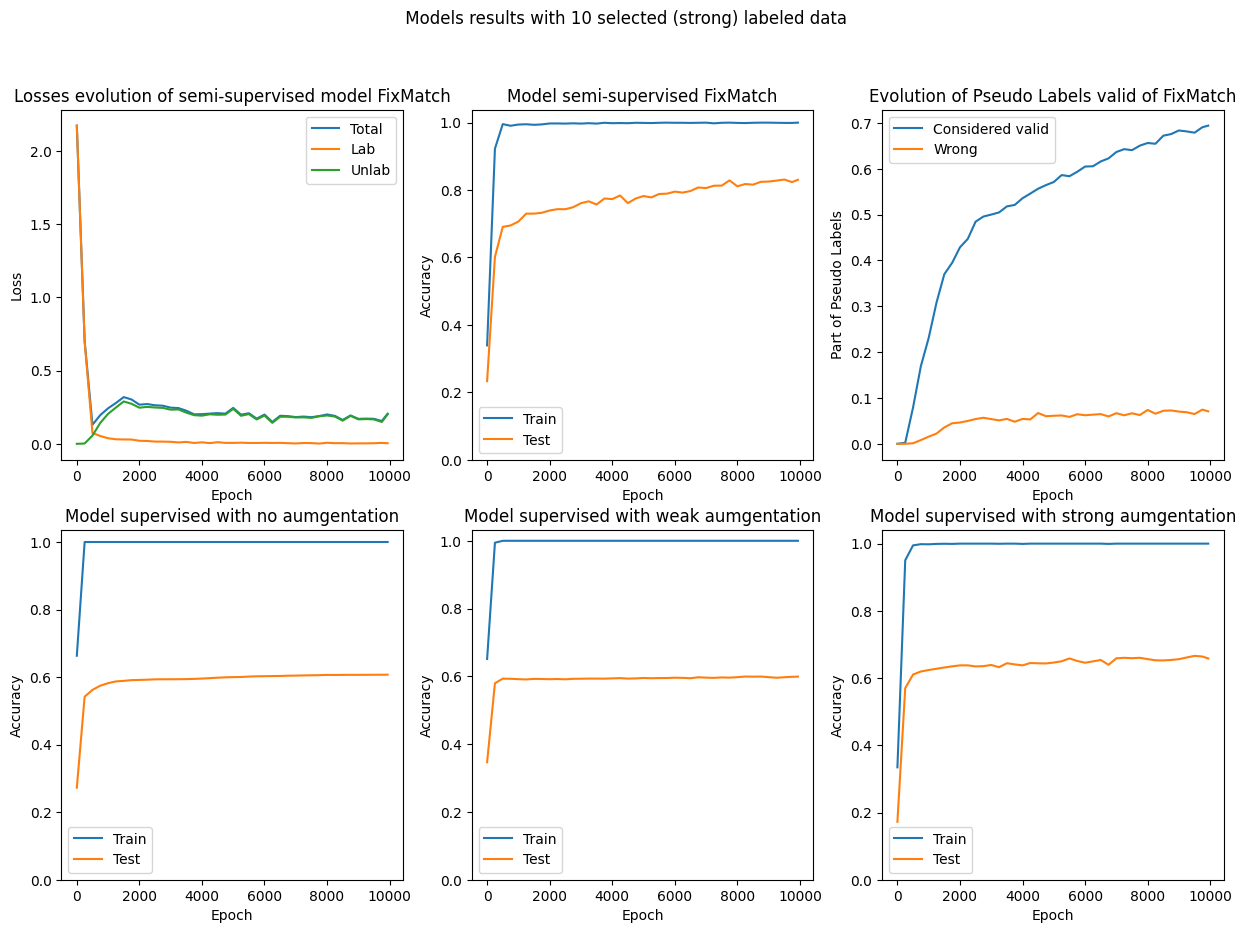

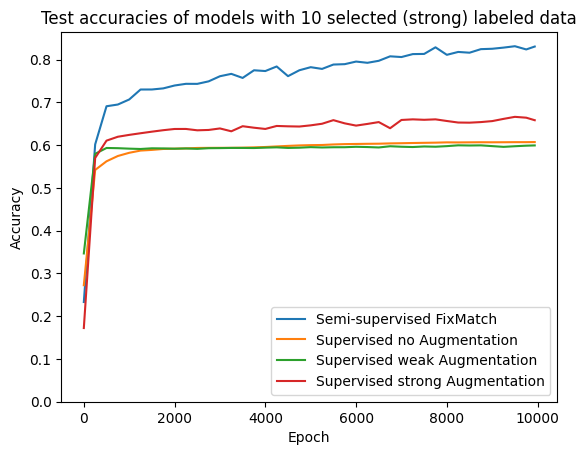

In [ ]:
draw_results_smooth(losses_10_select_s,losses_lab_10_select_s,losses_unlab_10_select_s,
 train_acc_FixMatch_10_select_s,test_acc_FixMatch_10_select_s,
 train_acc_noAug_10_select_s,test_acc_noAug_10_select_s,
 train_acc_weakAug_10_select_s,test_acc_weakAug_10_select_s,
 train_acc_strongAug_10_select_s,test_acc_strongAug_10_select_s,
 pseudo_lab_10_select_s,false_pseudo_lab_10_select_s,"10 selected (strong)")
save_results(losses_10_select_s,losses_lab_10_select_s,losses_unlab_10_select_s,
 train_acc_FixMatch_10_select_s,test_acc_FixMatch_10_select_s,
 train_acc_noAug_10_select_s,test_acc_noAug_10_select_s,
 train_acc_weakAug_10_select_s,test_acc_weakAug_10_select_s,
 train_acc_strongAug_10_select_s,test_acc_strongAug_10_select_s,
 pseudo_lab_10_select_s,false_pseudo_lab_10_select_s,"10 selected (strong)")

### 10 labels selected by weak augmentation

In [ ]:
index_w_10 = load_labels_indexes("top_1_indices_aug_weak.csv")
[losses_10_select_w,losses_lab_10_select_w,losses_unlab_10_select_w,
 train_acc_FixMatch_10_select_w,test_acc_FixMatch_10_select_w,
 train_acc_noAug_10_select_w,test_acc_noAug_10_select_w,
 train_acc_weakAug_10_select_w,test_acc_weakAug_10_select_w,
 train_acc_strongAug_10_select_w,test_acc_strongAug_10_selectw,
 pseudo_lab_10_select_w,false_pseudo_lab_10_select_w,cond_out_10_select_w] = train_FixMatch(10,10,7,10000, 250, list_of_index_for_label=index_w_10, threshold_loss= 0, threshold_acc= 0, threshold_pl= 0)

Epoch: 250, Loss: 0.46403035521507263, Loss lab: 0.46403035521507263, Loss unlab: 0.0, Train Accuracy: 1.0, Test Accuracy: 0.6118000149726868, Pseudo Labels: 0.0, Wrong Pseudo Labels 0.0
Epoch: 500, Loss: 0.3723999261856079, Loss lab: 0.32362470030784607, Loss unlab: 0.048775214701890945, Train Accuracy: 0.8999999761581421, Test Accuracy: 0.5950000286102295, Pseudo Labels: 0.04285714285714286, Wrong Pseudo Labels 0.0
Epoch: 750, Loss: 0.10521168261766434, Loss lab: 0.04626619443297386, Loss unlab: 0.058945488184690475, Train Accuracy: 1.0, Test Accuracy: 0.5386999845504761, Pseudo Labels: 0.2571428571428571, Wrong Pseudo Labels 0.04285714285714286
Epoch: 1000, Loss: 0.4995959401130676, Loss lab: 0.018873322755098343, Loss unlab: 0.4807226061820984, Train Accuracy: 1.0, Test Accuracy: 0.5709999799728394, Pseudo Labels: 0.2714285714285714, Wrong Pseudo Labels 0.05714285714285714
Epoch: 1250, Loss: 0.1562330722808838, Loss lab: 0.012152831070125103, Loss unlab: 0.1440802365541458, Train A

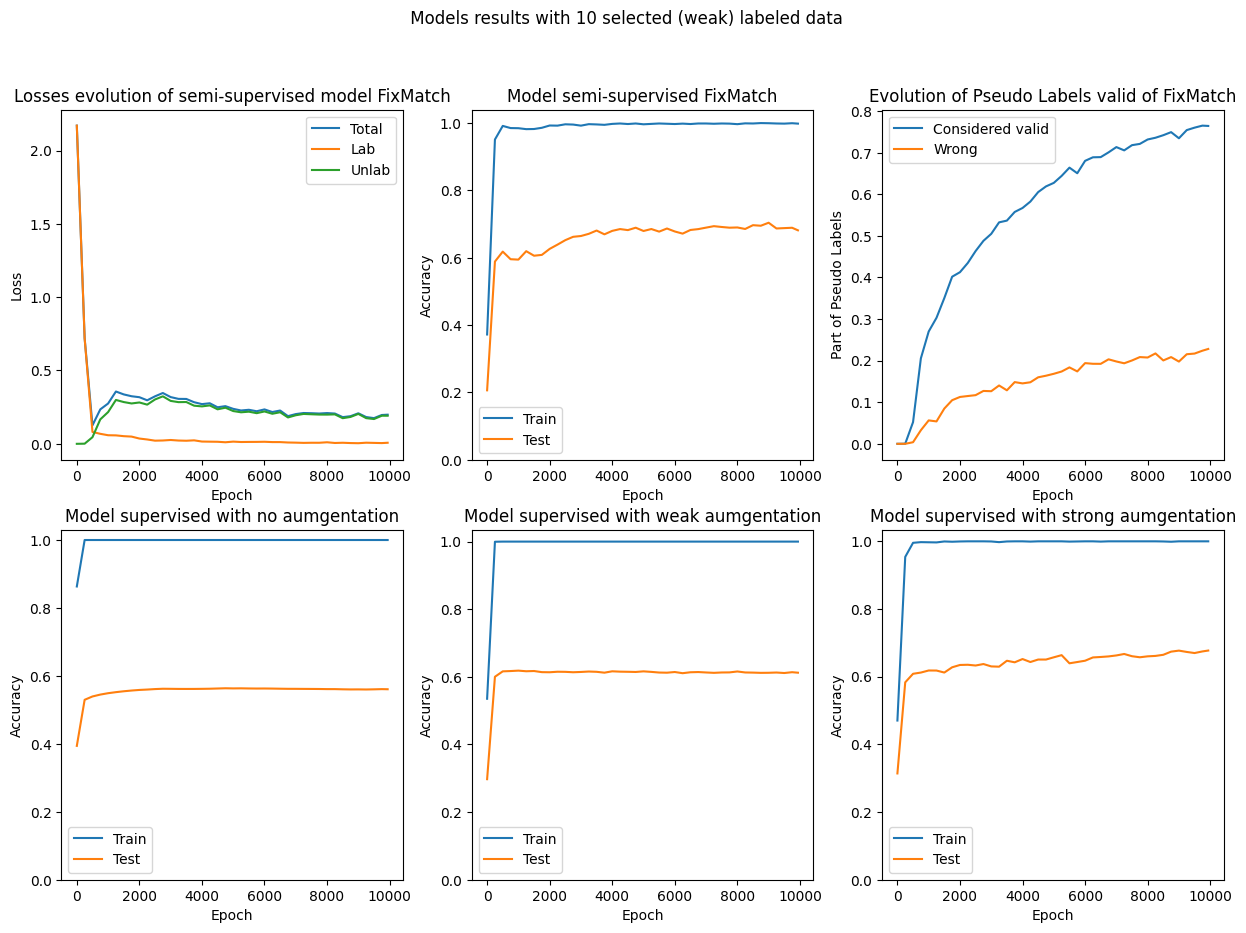

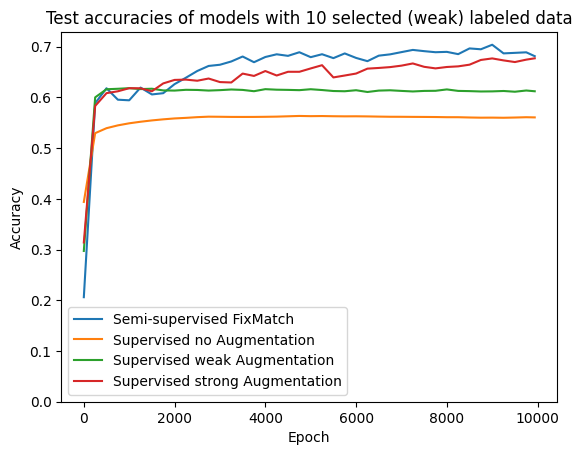

In [ ]:
draw_results_smooth(losses_10_select_w,losses_lab_10_select_w,losses_unlab_10_select_w,
 train_acc_FixMatch_10_select_w,test_acc_FixMatch_10_select_w,
 train_acc_noAug_10_select_w,test_acc_noAug_10_select_w,
 train_acc_weakAug_10_select_w,test_acc_weakAug_10_select_w,
 train_acc_strongAug_10_select_w,test_acc_strongAug_10_selectw,
 pseudo_lab_10_select_w,false_pseudo_lab_10_select_w,"10 selected (weak)")
save_results(losses_10_select_w,losses_lab_10_select_w,losses_unlab_10_select_w,
 train_acc_FixMatch_10_select_w,test_acc_FixMatch_10_select_w,
 train_acc_noAug_10_select_w,test_acc_noAug_10_select_w,
 train_acc_weakAug_10_select_w,test_acc_weakAug_10_select_w,
 train_acc_strongAug_10_select_w,test_acc_strongAug_10_selectw,
 pseudo_lab_10_select_w,false_pseudo_lab_10_select_w,"10 selected (weak)")

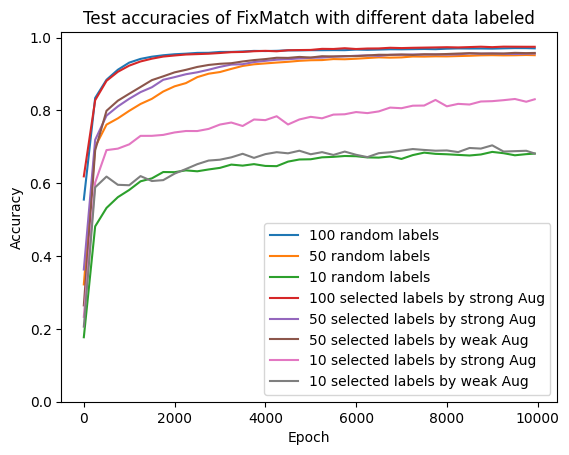

In [ ]:
draw_comparaison(test_acc_FixMatch_100,test_acc_FixMatch_50,test_acc_FixMatch_10,test_acc_FixMatch_100_select_s,test_acc_FixMatch_50_select_s,test_acc_FixMatch_50_select_w,test_acc_FixMatch_10_select_s,test_acc_FixMatch_10_select_w)